## 对BienData分子赛进行训练

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time,os,joblib
# from lightgbm.sklearn import LGBMRegressor
from datetime import datetime
import lightgbm as lgb

In [2]:
def localLoss(true_y,pred_y,show=False): # 官方给出的SMAPE loss 评价指标
    diff = np.abs(true_y - pred_y)
    absy_plus_babsp = (np.abs(true_y) + np.abs(pred_y)) / 2
    absy_plus_babsp = np.where(absy_plus_babsp==0,1e19,absy_plus_babsp) # 防止分母为0
    loss = sum(diff / absy_plus_babsp) * 100 / len(absy_plus_babsp)
    if show:
        print("local_loss__= {}".format(loss))
    return loss

### 1. 获取trainX 的单一值列，或缺失值列

In [4]:
def get_all_NaN_one_cols(csv_path,header='infer',sep=','):
    '''
    获取csv_path这个DataFrame中，所有值都是全部缺失值，全部某个单一值的列名
    :param csv_path:
    :param header:
    :param sep:
    :return:
    '''
    df=pd.read_csv(csv_path,header=header,sep=sep) if isinstance(csv_path,str) else csv_path
    remove_cols=[]
    for col in df.columns:
        if df[col].isnull().sum()==df.shape[0] or df[col].nunique()==1:
        #  全部都是缺失值，或全都是单一值，或全都是缺失值和单一值
        # if df[col].isnull().sum()==df.shape[0] or (df[col].nunique()==1 and df[col].isnull().sum() == 0):
            # 全都是缺失值，或全都是单一值
            remove_cols.append(col)
    use_cols=list(set(df.columns)-set(remove_cols))
    print('All cols num: {},remove cols num: {}, use cols num: {}'.format(df.shape[1],len(remove_cols),len(use_cols)))
    return use_cols,remove_cols

In [5]:
path=r'E:\PyProjects\DataSet\Molecules\RawData\molecule_open_data/'
use_cols,remove_cols=get_all_NaN_one_cols(path+"candidate_train.csv")

All cols num: 3178,remove cols num: 51, use cols num: 3127


In [7]:
','.join(remove_cols)

'0,1,2,3,4,5,19,21,26,32,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78'

### 2. 准备trainX,trainy

In [11]:
def prepare_trainset(train_path,label_path,label_col='p1'):
    drop_cols=['0','1','2','3','4','5','19','21','26','32','38','39','40','41','42','43','44','45','46','47','48',
               '49','50','51','52','53','54','55','56','57','58','59','60','61',
              '62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78']
    use_cols=[str(i) for i in range(0,3177) if str(i) not in drop_cols]+['id']
    train_df=pd.read_csv(train_path,usecols=use_cols)
    label_df=pd.read_csv(label_path,usecols=[label_col,'id'])
    all_df=train_df.merge(label_df,on='id',how='left')
    trainy=all_df[label_col]
    trainX=all_df.drop([label_col,'id'],axis=1)
    return trainX,trainy

In [12]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p1')

In [14]:
trainX.shape

(79267, 3126)

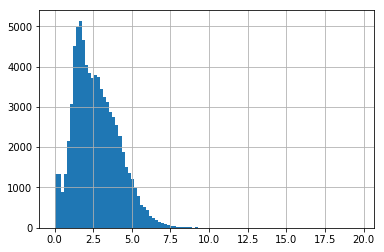

In [15]:
trainy.hist(bins=100)

#### 以上表示数据集加载成功

### 3. 模型训练

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time,os,joblib
from lightgbm.sklearn import LGBMRegressor
from datetime import datetime
import lightgbm as lgb

def localLoss(true_y,pred_y,show=False): # 官方给出的SMAPE loss 评价指标
    diff = np.abs(true_y - pred_y)
    absy_plus_babsp = (np.abs(true_y) + np.abs(pred_y)) / 2
    absy_plus_babsp = np.where(absy_plus_babsp==0,1e19,absy_plus_babsp) # 防止分母为0
    loss = sum(diff / absy_plus_babsp) * 100 / len(absy_plus_babsp)
    if show:
        print("local_loss__= {}".format(loss))
    return loss


def train_single_LGB(trainX,trainy, save_folder,seed_num=2, n_splits=5,lr=0.01):
    '''
    使用trainX,trainy, valX,valy来训练单个LGB回归器，使用K折样本融合的方式
    :param trainX:
    :param trainy:
    :param save_folder: 模型保存文件夹
    :param target_index:
    :param seed_num: 随机数的个数，每个随机数产生一个n_splits的交叉验证模型
    :param n_splits: 交叉验证的折数
    :return:
    '''

    def local_loss(y_true, y_pred):
        return 'local_loss', localLoss(y_true, y_pred), False
    os.makedirs(save_folder,exist_ok=True)
    pred_results=None
    print('trainX shape: {}'.format(trainX.shape))
    seedRandom = list(np.random.randint(0, 1000, 1000)) # 一千个随机数
    losses=[]
    for index, seed in enumerate(seedRandom[:seed_num]): # eg seed_num=3: enumerate([607,235,424])
        print("idx: {}, seed:{}, num:{}....".format(index,seed, seed_num))
        skf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        preds = np.zeros((trainX.shape[0],))
        for fold_, (trn_idx, val_idx) in enumerate(skf.split(trainX)):
            print("start to train on fold {}".format(fold_ + 1))
            trnX,trny = trainX.iloc[trn_idx], trainy.iloc[trn_idx]
            valX,valy = trainX.iloc[val_idx], trainy.iloc[val_idx]
            t0=time.time()
            model=LGBMRegressor(boosting_type='gbdt',num_leaves=301,learning_rate=lr,n_estimators=10000,
                                feature_fraction=0.8,bagging_fraction=0.8)
            model.fit(trnX,trny,eval_set=[(valX,valy)],eval_metric=local_loss,early_stopping_rounds=50,verbose=50)
            save_name = 'LGBM_' +str(seed)+'_' + str(fold_)+ '_'+datetime.now().strftime('%Y%m%d_%H%M%S')
            joblib.dump(model, os.path.join(save_folder, save_name))
            print('model is fitted, take time {:.4f}, model is saved to {}'.format(time.time()-t0, save_name))
            preds[val_idx] = model.predict(valX, num_iteration=model.best_iteration_)
            print('画特征重要性排序...')
            lgb.plot_importance(model, max_num_features=30,title= 'LGBM_' +str(seed)+'_' + str(fold_))  # max_features表示最多展示出前10个重要性特征，可以自行设置
            plt.show()

        if index==0:pred_results=pd.DataFrame(preds,columns=['round_0'])
        else: pred_results['round_'+str(index)]=preds
        # 查看这个round的local loss
        loss=localLoss(trainy,preds,True)
        losses.append(loss)
    ## 最终通过平均法对pred_results计算最终预测结果，得到最终losses:
    pred_results['mean']=pred_results.mean(axis=1)
    final_loss=localLoss(trainy,pred_results['mean'].values,True)
    losses.append(final_loss)
    return losses

trainX shape: (79267, 3126)
idx: 0, seed:940, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.684518	valid_0's local_loss: 26.8837
[100]	valid_0's l2: 0.600518	valid_0's local_loss: 24.2449
[150]	valid_0's l2: 0.571561	valid_0's local_loss: 23.6012
[200]	valid_0's l2: 0.557596	valid_0's local_loss: 23.2998
[250]	valid_0's l2: 0.54926	valid_0's local_loss: 23.1038
[300]	valid_0's l2: 0.542645	valid_0's local_loss: 22.9691
[350]	valid_0's l2: 0.537306	valid_0's local_loss: 22.8574
[400]	valid_0's l2: 0.532592	valid_0's local_loss: 22.7458
[450]	valid_0's l2: 0.52913	valid_0's local_loss: 22.6739
[500]	valid_0's l2: 0.526261	valid_0's local_loss: 22.6004
[550]	valid_0's l2: 0.523855	valid_0's local_loss: 22.5559
[600]	valid_0's l2: 0.521462	valid_0's local_loss: 22.507
[650]	valid_0's l2: 0.520021	valid_0's local_loss: 22.4705
[700]	valid_0's l2: 0.518235	valid_0's local_loss: 22.4408
[750]	valid_0's l2: 0.516563	valid_0

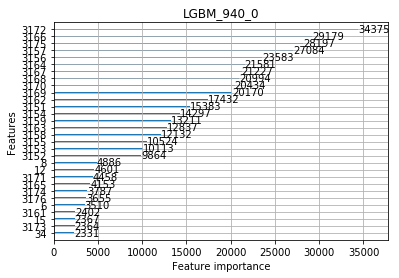

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.694948	valid_0's local_loss: 26.7663
[100]	valid_0's l2: 0.611229	valid_0's local_loss: 24.0713
[150]	valid_0's l2: 0.582741	valid_0's local_loss: 23.4385
[200]	valid_0's l2: 0.568352	valid_0's local_loss: 23.1469
[250]	valid_0's l2: 0.559481	valid_0's local_loss: 22.9551
[300]	valid_0's l2: 0.552143	valid_0's local_loss: 22.7871
[350]	valid_0's l2: 0.54698	valid_0's local_loss: 22.6444
[400]	valid_0's l2: 0.542121	valid_0's local_loss: 22.5278
[450]	valid_0's l2: 0.538309	valid_0's local_loss: 22.4318
[500]	valid_0's l2: 0.534772	valid_0's local_loss: 22.3443
[550]	valid_0's l2: 0.532097	valid_0's local_loss: 22.282
[600]	valid_0's l2: 0.529713	valid_0's local_loss: 22.2437
[650]	valid_0's l2: 0.527496	valid_0's local_loss: 22.2011
[700]	valid_0's l2: 0.525295	valid_0's local_loss: 22.1582
[750]	valid_0's l2: 0.5236	valid_0's local_loss: 22.1372
[800]	valid_0's l2: 0.521909	valid

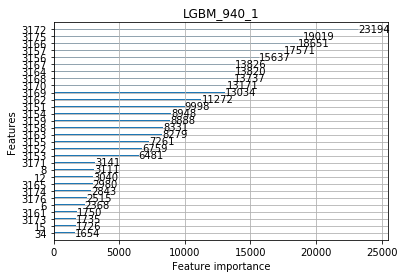

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.691335	valid_0's local_loss: 26.8562
[100]	valid_0's l2: 0.603745	valid_0's local_loss: 24.1199
[150]	valid_0's l2: 0.57381	valid_0's local_loss: 23.4964
[200]	valid_0's l2: 0.558775	valid_0's local_loss: 23.193
[250]	valid_0's l2: 0.549992	valid_0's local_loss: 23.007
[300]	valid_0's l2: 0.542809	valid_0's local_loss: 22.8699
[350]	valid_0's l2: 0.536983	valid_0's local_loss: 22.7392
[400]	valid_0's l2: 0.532494	valid_0's local_loss: 22.6523
[450]	valid_0's l2: 0.528751	valid_0's local_loss: 22.5688
[500]	valid_0's l2: 0.525689	valid_0's local_loss: 22.492
[550]	valid_0's l2: 0.523437	valid_0's local_loss: 22.4514
[600]	valid_0's l2: 0.521299	valid_0's local_loss: 22.4237
[650]	valid_0's l2: 0.519506	valid_0's local_loss: 22.407
[700]	valid_0's l2: 0.517634	valid_0's local_loss: 22.37
[750]	valid_0's l2: 0.51632	valid_0's local_loss: 22.345
[800]	valid_0's l2: 0.514679	valid_0's 

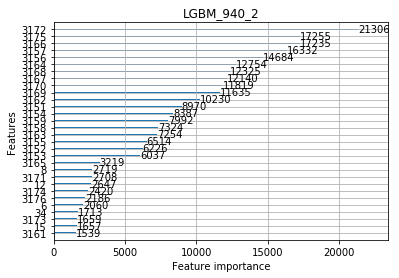

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.682541	valid_0's local_loss: 27.0933
[100]	valid_0's l2: 0.603134	valid_0's local_loss: 24.3742
[150]	valid_0's l2: 0.573925	valid_0's local_loss: 23.6932
[200]	valid_0's l2: 0.55958	valid_0's local_loss: 23.39
[250]	valid_0's l2: 0.549418	valid_0's local_loss: 23.1731
[300]	valid_0's l2: 0.542279	valid_0's local_loss: 23.0355
[350]	valid_0's l2: 0.536296	valid_0's local_loss: 22.9188
[400]	valid_0's l2: 0.532226	valid_0's local_loss: 22.8176
[450]	valid_0's l2: 0.528586	valid_0's local_loss: 22.7387
[500]	valid_0's l2: 0.525814	valid_0's local_loss: 22.6837
[550]	valid_0's l2: 0.523299	valid_0's local_loss: 22.6223
[600]	valid_0's l2: 0.521094	valid_0's local_loss: 22.5919
[650]	valid_0's l2: 0.518931	valid_0's local_loss: 22.5507
[700]	valid_0's l2: 0.517084	valid_0's local_loss: 22.5208
[750]	valid_0's l2: 0.515675	valid_0's local_loss: 22.4933
[800]	valid_0's l2: 0.514416	vali

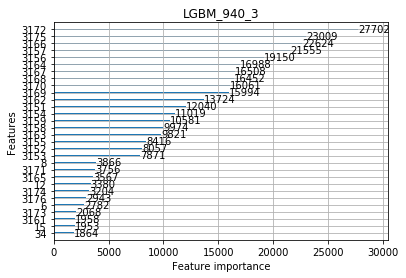

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.681687	valid_0's local_loss: 26.6353
[100]	valid_0's l2: 0.599564	valid_0's local_loss: 24.014
[150]	valid_0's l2: 0.569867	valid_0's local_loss: 23.3309
[200]	valid_0's l2: 0.557071	valid_0's local_loss: 23.0516
[250]	valid_0's l2: 0.549126	valid_0's local_loss: 22.8958
[300]	valid_0's l2: 0.542651	valid_0's local_loss: 22.7736
[350]	valid_0's l2: 0.537544	valid_0's local_loss: 22.6603
[400]	valid_0's l2: 0.533728	valid_0's local_loss: 22.5677
[450]	valid_0's l2: 0.530835	valid_0's local_loss: 22.5247
[500]	valid_0's l2: 0.528347	valid_0's local_loss: 22.4759
[550]	valid_0's l2: 0.526048	valid_0's local_loss: 22.4336
[600]	valid_0's l2: 0.524387	valid_0's local_loss: 22.4038
[650]	valid_0's l2: 0.522676	valid_0's local_loss: 22.3723
[700]	valid_0's l2: 0.520916	valid_0's local_loss: 22.3191
[750]	valid_0's l2: 0.519411	valid_0's local_loss: 22.2728
[800]	valid_0's l2: 0.518003	va

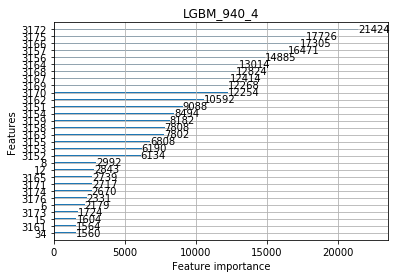

local_loss__= 22.10358092927971
idx: 1, seed:442, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.67395	valid_0's local_loss: 26.7965
[100]	valid_0's l2: 0.593283	valid_0's local_loss: 24.161
[150]	valid_0's l2: 0.565008	valid_0's local_loss: 23.5362
[200]	valid_0's l2: 0.550909	valid_0's local_loss: 23.2611
[250]	valid_0's l2: 0.542265	valid_0's local_loss: 23.072
[300]	valid_0's l2: 0.536135	valid_0's local_loss: 22.9354
[350]	valid_0's l2: 0.531744	valid_0's local_loss: 22.8327
[400]	valid_0's l2: 0.527691	valid_0's local_loss: 22.7335
[450]	valid_0's l2: 0.524204	valid_0's local_loss: 22.6556
[500]	valid_0's l2: 0.521151	valid_0's local_loss: 22.5911
[550]	valid_0's l2: 0.518624	valid_0's local_loss: 22.5347
[600]	valid_0's l2: 0.51646	valid_0's local_loss: 22.4804
[650]	valid_0's l2: 0.514457	valid_0's local_loss: 22.4377
[700]	valid_0's l2: 0.512776	valid_0's local_loss: 22.4192
[750]	valid_0's l2: 0.511225	vali

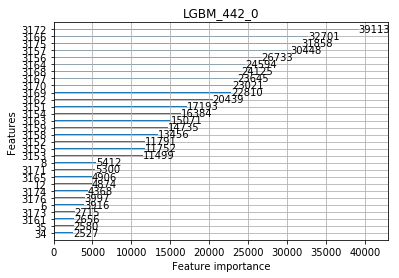

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.698626	valid_0's local_loss: 26.9297
[100]	valid_0's l2: 0.613538	valid_0's local_loss: 24.2424
[150]	valid_0's l2: 0.583374	valid_0's local_loss: 23.5584
[200]	valid_0's l2: 0.569832	valid_0's local_loss: 23.2723
[250]	valid_0's l2: 0.559881	valid_0's local_loss: 23.0794
[300]	valid_0's l2: 0.552167	valid_0's local_loss: 22.9298
[350]	valid_0's l2: 0.546576	valid_0's local_loss: 22.8047
[400]	valid_0's l2: 0.541315	valid_0's local_loss: 22.7077
[450]	valid_0's l2: 0.536857	valid_0's local_loss: 22.6156
[500]	valid_0's l2: 0.533648	valid_0's local_loss: 22.5434
[550]	valid_0's l2: 0.530401	valid_0's local_loss: 22.5065
[600]	valid_0's l2: 0.527485	valid_0's local_loss: 22.4369
[650]	valid_0's l2: 0.525312	valid_0's local_loss: 22.3868
[700]	valid_0's l2: 0.523257	valid_0's local_loss: 22.3513
[750]	valid_0's l2: 0.521642	valid_0's local_loss: 22.3104
[800]	valid_0's l2: 0.519865	v

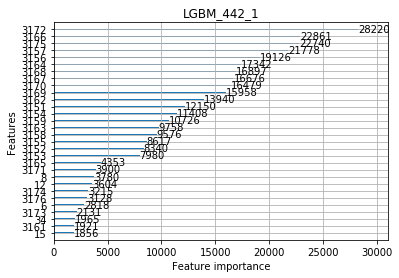

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.69607	valid_0's local_loss: 26.8114
[100]	valid_0's l2: 0.614743	valid_0's local_loss: 24.2387
[150]	valid_0's l2: 0.585331	valid_0's local_loss: 23.5833
[200]	valid_0's l2: 0.571641	valid_0's local_loss: 23.2894
[250]	valid_0's l2: 0.56165	valid_0's local_loss: 23.0622
[300]	valid_0's l2: 0.554354	valid_0's local_loss: 22.9148
[350]	valid_0's l2: 0.549798	valid_0's local_loss: 22.8049
[400]	valid_0's l2: 0.545022	valid_0's local_loss: 22.7194
[450]	valid_0's l2: 0.540934	valid_0's local_loss: 22.6466
[500]	valid_0's l2: 0.537854	valid_0's local_loss: 22.5644
[550]	valid_0's l2: 0.535298	valid_0's local_loss: 22.5059
[600]	valid_0's l2: 0.533141	valid_0's local_loss: 22.4349
[650]	valid_0's l2: 0.530677	valid_0's local_loss: 22.3671
[700]	valid_0's l2: 0.528724	valid_0's local_loss: 22.3282
[750]	valid_0's l2: 0.527056	valid_0's local_loss: 22.2881
[800]	valid_0's l2: 0.525711	val

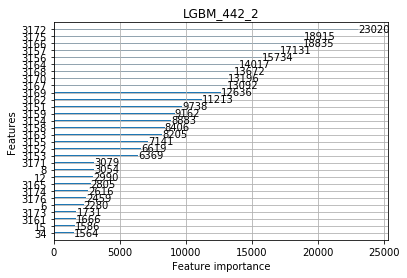

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.673841	valid_0's local_loss: 26.6943
[100]	valid_0's l2: 0.588223	valid_0's local_loss: 23.918
[150]	valid_0's l2: 0.559134	valid_0's local_loss: 23.3105
[200]	valid_0's l2: 0.54446	valid_0's local_loss: 23.0198
[250]	valid_0's l2: 0.535567	valid_0's local_loss: 22.8508
[300]	valid_0's l2: 0.529428	valid_0's local_loss: 22.7139
[350]	valid_0's l2: 0.524349	valid_0's local_loss: 22.6376
[400]	valid_0's l2: 0.520112	valid_0's local_loss: 22.5448
[450]	valid_0's l2: 0.516243	valid_0's local_loss: 22.4604
[500]	valid_0's l2: 0.512965	valid_0's local_loss: 22.377
[550]	valid_0's l2: 0.51062	valid_0's local_loss: 22.3212
[600]	valid_0's l2: 0.50848	valid_0's local_loss: 22.2705
[650]	valid_0's l2: 0.506498	valid_0's local_loss: 22.2304
[700]	valid_0's l2: 0.504836	valid_0's local_loss: 22.1965
[750]	valid_0's l2: 0.503163	valid_0's local_loss: 22.1708
[800]	valid_0's l2: 0.502056	valid_

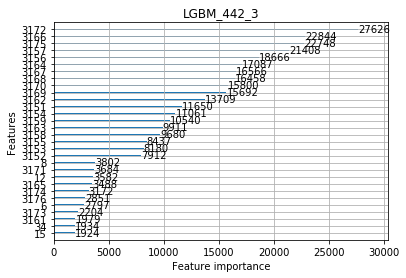

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.686385	valid_0's local_loss: 26.9945
[100]	valid_0's l2: 0.608618	valid_0's local_loss: 24.3285
[150]	valid_0's l2: 0.579337	valid_0's local_loss: 23.6307
[200]	valid_0's l2: 0.564803	valid_0's local_loss: 23.3243
[250]	valid_0's l2: 0.555346	valid_0's local_loss: 23.1289
[300]	valid_0's l2: 0.548464	valid_0's local_loss: 22.973
[350]	valid_0's l2: 0.54298	valid_0's local_loss: 22.8577
[400]	valid_0's l2: 0.538815	valid_0's local_loss: 22.764
[450]	valid_0's l2: 0.535386	valid_0's local_loss: 22.6858
[500]	valid_0's l2: 0.532553	valid_0's local_loss: 22.6173
[550]	valid_0's l2: 0.530098	valid_0's local_loss: 22.572
[600]	valid_0's l2: 0.528458	valid_0's local_loss: 22.553
[650]	valid_0's l2: 0.526478	valid_0's local_loss: 22.5087
[700]	valid_0's l2: 0.524636	valid_0's local_loss: 22.4725
[750]	valid_0's l2: 0.523213	valid_0's local_loss: 22.4464
[800]	valid_0's l2: 0.521962	valid_

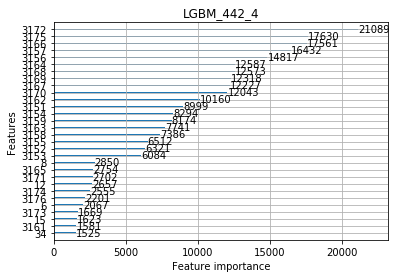

local_loss__= 22.096007141500053
idx: 2, seed:508, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.739378	valid_0's local_loss: 26.8271
[100]	valid_0's l2: 0.647796	valid_0's local_loss: 24.198
[150]	valid_0's l2: 0.614965	valid_0's local_loss: 23.5327
[200]	valid_0's l2: 0.59991	valid_0's local_loss: 23.245
[250]	valid_0's l2: 0.591121	valid_0's local_loss: 23.07
[300]	valid_0's l2: 0.584122	valid_0's local_loss: 22.9425
[350]	valid_0's l2: 0.578009	valid_0's local_loss: 22.8088
[400]	valid_0's l2: 0.57303	valid_0's local_loss: 22.7137
[450]	valid_0's l2: 0.568764	valid_0's local_loss: 22.6277
[500]	valid_0's l2: 0.56546	valid_0's local_loss: 22.5588
[550]	valid_0's l2: 0.56152	valid_0's local_loss: 22.487
[600]	valid_0's l2: 0.558897	valid_0's local_loss: 22.4241
[650]	valid_0's l2: 0.556982	valid_0's local_loss: 22.3906
[700]	valid_0's l2: 0.554992	valid_0's local_loss: 22.3548
[750]	valid_0's l2: 0.553316	valid_0'

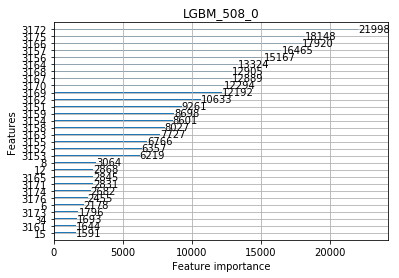

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.680399	valid_0's local_loss: 26.9462
[100]	valid_0's l2: 0.598608	valid_0's local_loss: 24.2339
[150]	valid_0's l2: 0.569514	valid_0's local_loss: 23.5803
[200]	valid_0's l2: 0.555233	valid_0's local_loss: 23.259
[250]	valid_0's l2: 0.546631	valid_0's local_loss: 23.0824
[300]	valid_0's l2: 0.540576	valid_0's local_loss: 22.9556
[350]	valid_0's l2: 0.535632	valid_0's local_loss: 22.843
[400]	valid_0's l2: 0.531628	valid_0's local_loss: 22.7549
[450]	valid_0's l2: 0.527768	valid_0's local_loss: 22.6856
[500]	valid_0's l2: 0.524601	valid_0's local_loss: 22.6159
[550]	valid_0's l2: 0.522048	valid_0's local_loss: 22.5681
[600]	valid_0's l2: 0.519871	valid_0's local_loss: 22.5217
[650]	valid_0's l2: 0.517666	valid_0's local_loss: 22.4762
[700]	valid_0's l2: 0.515819	valid_0's local_loss: 22.4249
[750]	valid_0's l2: 0.514297	valid_0's local_loss: 22.401
[800]	valid_0's l2: 0.51272	valid

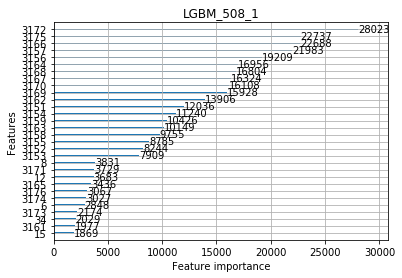

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.672406	valid_0's local_loss: 27.0259
[100]	valid_0's l2: 0.593604	valid_0's local_loss: 24.2021
[150]	valid_0's l2: 0.563691	valid_0's local_loss: 23.5377
[200]	valid_0's l2: 0.549769	valid_0's local_loss: 23.2242
[250]	valid_0's l2: 0.539041	valid_0's local_loss: 23.0013
[300]	valid_0's l2: 0.531774	valid_0's local_loss: 22.8328
[350]	valid_0's l2: 0.526142	valid_0's local_loss: 22.7314
[400]	valid_0's l2: 0.521613	valid_0's local_loss: 22.6165
[450]	valid_0's l2: 0.518212	valid_0's local_loss: 22.5587
[500]	valid_0's l2: 0.51531	valid_0's local_loss: 22.4821
[550]	valid_0's l2: 0.512506	valid_0's local_loss: 22.4084
[600]	valid_0's l2: 0.510099	valid_0's local_loss: 22.3437
[650]	valid_0's l2: 0.508275	valid_0's local_loss: 22.2957
[700]	valid_0's l2: 0.50671	valid_0's local_loss: 22.2581
[750]	valid_0's l2: 0.505147	valid_0's local_loss: 22.2359
[800]	valid_0's l2: 0.503681	val

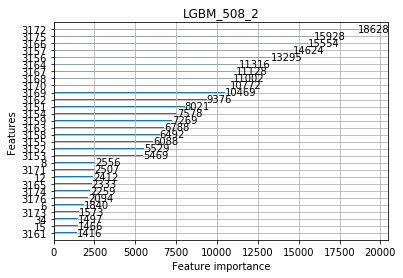

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.686744	valid_0's local_loss: 26.8045
[100]	valid_0's l2: 0.603064	valid_0's local_loss: 24.2145
[150]	valid_0's l2: 0.57273	valid_0's local_loss: 23.5489
[200]	valid_0's l2: 0.557656	valid_0's local_loss: 23.2572
[250]	valid_0's l2: 0.547695	valid_0's local_loss: 23.0575
[300]	valid_0's l2: 0.540099	valid_0's local_loss: 22.8936
[350]	valid_0's l2: 0.534327	valid_0's local_loss: 22.7694
[400]	valid_0's l2: 0.529852	valid_0's local_loss: 22.6809
[450]	valid_0's l2: 0.526539	valid_0's local_loss: 22.6108
[500]	valid_0's l2: 0.523285	valid_0's local_loss: 22.5377
[550]	valid_0's l2: 0.520657	valid_0's local_loss: 22.4723
[600]	valid_0's l2: 0.518158	valid_0's local_loss: 22.4155
[650]	valid_0's l2: 0.516504	valid_0's local_loss: 22.3774
[700]	valid_0's l2: 0.514772	valid_0's local_loss: 22.3228
[750]	valid_0's l2: 0.512895	valid_0's local_loss: 22.2813
[800]	valid_0's l2: 0.511577	va

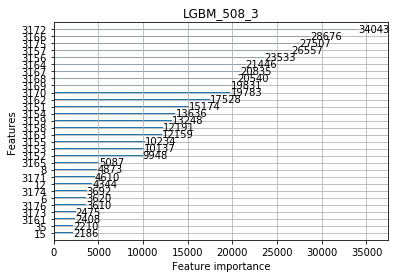

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.654324	valid_0's local_loss: 26.5786
[100]	valid_0's l2: 0.577679	valid_0's local_loss: 23.9642
[150]	valid_0's l2: 0.549782	valid_0's local_loss: 23.3327
[200]	valid_0's l2: 0.535332	valid_0's local_loss: 23.0534
[250]	valid_0's l2: 0.526058	valid_0's local_loss: 22.8559
[300]	valid_0's l2: 0.519483	valid_0's local_loss: 22.7322
[350]	valid_0's l2: 0.514608	valid_0's local_loss: 22.6176
[400]	valid_0's l2: 0.510228	valid_0's local_loss: 22.5165
[450]	valid_0's l2: 0.506659	valid_0's local_loss: 22.4463
[500]	valid_0's l2: 0.503266	valid_0's local_loss: 22.3857
[550]	valid_0's l2: 0.500953	valid_0's local_loss: 22.3266
[600]	valid_0's l2: 0.498769	valid_0's local_loss: 22.2611
[650]	valid_0's l2: 0.496901	valid_0's local_loss: 22.2217
[700]	valid_0's l2: 0.495214	valid_0's local_loss: 22.1945
[750]	valid_0's l2: 0.493459	valid_0's local_loss: 22.1492
[800]	valid_0's l2: 0.492169	v

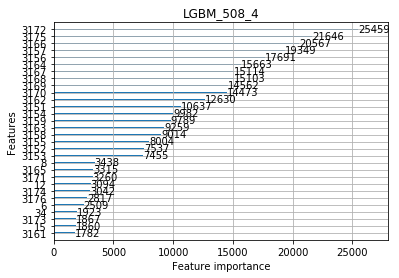

local_loss__= 22.050210907460833
local_loss__= 21.604520992631716


In [41]:
losses=train_single_LGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\Models/Model_p1',
                 seed_num=3, n_splits=5,lr=0.04342)

### 3.2 训练p2模型

In [4]:
def prepare_trainset(train_path,label_path,label_col='p1'):
    drop_cols=['0','1','2','3','4','5','19','21','26','32','38','39','40','41','42','43','44','45','46','47','48',
               '49','50','51','52','53','54','55','56','57','58','59','60','61',
              '62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78']
    use_cols=[str(i) for i in range(0,3177) if str(i) not in drop_cols]+['id']
    train_df=pd.read_csv(train_path,usecols=use_cols)
    label_df=pd.read_csv(label_path,usecols=[label_col,'id'])
    all_df=train_df.merge(label_df,on='id',how='left')
    trainy=all_df[label_col]
    trainX=all_df.drop([label_col,'id'],axis=1)
    return trainX,trainy

In [6]:
path=r'E:\PyProjects\DataSet\Molecules\RawData\molecule_open_data/'
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p2')

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import time,os,joblib
from lightgbm.sklearn import LGBMRegressor
from datetime import datetime
import lightgbm as lgb

def localLoss(true_y,pred_y,show=False): # 官方给出的SMAPE loss 评价指标
    diff = np.abs(true_y - pred_y)
    absy_plus_babsp = (np.abs(true_y) + np.abs(pred_y)) / 2
    absy_plus_babsp = np.where(absy_plus_babsp==0,1e19,absy_plus_babsp) # 防止分母为0
    loss = sum(diff / absy_plus_babsp) * 100 / len(absy_plus_babsp)
    if show:
        print("local_loss__= {}".format(loss))
    return loss


def train_single_LGB(trainX,trainy, save_folder,seed_num=2, n_splits=5,lr=0.01):
    '''
    使用trainX,trainy, valX,valy来训练单个LGB回归器，使用K折样本融合的方式
    :param trainX:
    :param trainy:
    :param save_folder: 模型保存文件夹
    :param target_index:
    :param seed_num: 随机数的个数，每个随机数产生一个n_splits的交叉验证模型
    :param n_splits: 交叉验证的折数
    :return:
    '''

    def local_loss(y_true, y_pred):
        return 'local_loss', localLoss(y_true, y_pred), False
    os.makedirs(save_folder,exist_ok=True)
    pred_results=None
    print('trainX shape: {}'.format(trainX.shape))
    seedRandom = list(np.random.randint(0, 1000, 1000)) # 一千个随机数
    losses=[]
    for index, seed in enumerate(seedRandom[:seed_num]): # eg seed_num=3: enumerate([607,235,424])
        print("idx: {}, seed:{}, num:{}....".format(index,seed, seed_num))
        skf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        preds = np.zeros((trainX.shape[0],))
        for fold_, (trn_idx, val_idx) in enumerate(skf.split(trainX)):
            print("start to train on fold {}".format(fold_ + 1))
            trnX,trny = trainX.iloc[trn_idx], trainy.iloc[trn_idx]
            valX,valy = trainX.iloc[val_idx], trainy.iloc[val_idx]
            t0=time.time()
            model=LGBMRegressor(boosting_type='gbdt',num_leaves=301,learning_rate=lr,n_estimators=10000,
                                feature_fraction=0.8,bagging_fraction=0.8)
            model.fit(trnX,trny,eval_set=[(valX,valy)],eval_metric=local_loss,early_stopping_rounds=50,verbose=50)
            save_name = 'LGBM_' +str(seed)+'_' + str(fold_)+ '_'+datetime.now().strftime('%Y%m%d_%H%M%S')
            joblib.dump(model, os.path.join(save_folder, save_name))
            print('model is fitted, take time {:.4f}, model is saved to {}'.format(time.time()-t0, save_name))
            preds[val_idx] = model.predict(valX, num_iteration=model.best_iteration_)
            print('画特征重要性排序...')
            lgb.plot_importance(model, max_num_features=30,title= 'LGBM_' +str(seed)+'_' + str(fold_))  # max_features表示最多展示出前10个重要性特征，可以自行设置
            plt.show()

        if index==0:pred_results=pd.DataFrame(preds,columns=['round_0'])
        else: pred_results['round_'+str(index)]=preds
        # 查看这个round的local loss
        loss=localLoss(trainy,preds,True)
        losses.append(loss)
    ## 最终通过平均法对pred_results计算最终预测结果，得到最终losses:
    pred_results['mean']=pred_results.mean(axis=1)
    final_loss=localLoss(trainy,pred_results['mean'].values,True)
    losses.append(final_loss)
    return losses

trainX shape: (79267, 3126)
idx: 0, seed:333, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.44508e-05	valid_0's local_loss: 2.56054
[100]	valid_0's l2: 4.96477e-05	valid_0's local_loss: 2.2326
[150]	valid_0's l2: 4.53778e-05	valid_0's local_loss: 2.12697
[200]	valid_0's l2: 4.34245e-05	valid_0's local_loss: 2.07592
[250]	valid_0's l2: 4.21988e-05	valid_0's local_loss: 2.04203
[300]	valid_0's l2: 4.14014e-05	valid_0's local_loss: 2.01871
[350]	valid_0's l2: 4.07652e-05	valid_0's local_loss: 2.00013
[400]	valid_0's l2: 4.01819e-05	valid_0's local_loss: 1.98317
[450]	valid_0's l2: 3.97815e-05	valid_0's local_loss: 1.97009
[500]	valid_0's l2: 3.94486e-05	valid_0's local_loss: 1.96084
[550]	valid_0's l2: 3.91783e-05	valid_0's local_loss: 1.95285
[600]	valid_0's l2: 3.89457e-05	valid_0's local_loss: 1.9459
[650]	valid_0's l2: 3.87606e-05	valid_0's local_loss: 1.93998
[700]	valid_0's l2: 3.85881e-05	valid_0's local_loss: 1

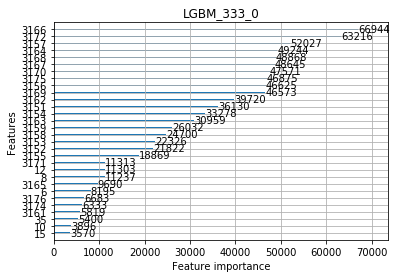

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.58025e-05	valid_0's local_loss: 2.58588
[100]	valid_0's l2: 5.11544e-05	valid_0's local_loss: 2.25465
[150]	valid_0's l2: 4.67226e-05	valid_0's local_loss: 2.14256
[200]	valid_0's l2: 4.46661e-05	valid_0's local_loss: 2.08837
[250]	valid_0's l2: 4.35143e-05	valid_0's local_loss: 2.05675
[300]	valid_0's l2: 4.26473e-05	valid_0's local_loss: 2.03224
[350]	valid_0's l2: 4.20065e-05	valid_0's local_loss: 2.01372
[400]	valid_0's l2: 4.1496e-05	valid_0's local_loss: 1.99868
[450]	valid_0's l2: 4.10393e-05	valid_0's local_loss: 1.98539
[500]	valid_0's l2: 4.07314e-05	valid_0's local_loss: 1.97664
[550]	valid_0's l2: 4.0481e-05	valid_0's local_loss: 1.96971
[600]	valid_0's l2: 4.02397e-05	valid_0's local_loss: 1.96284
[650]	valid_0's l2: 4.00399e-05	valid_0's local_loss: 1.95704
[700]	valid_0's l2: 3.98793e-05	valid_0's local_loss: 1.95282
[750]	valid_0's l2: 3.97559e-05	valid_0's local_l

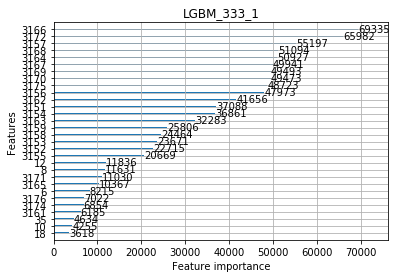

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.71216e-05	valid_0's local_loss: 2.58805
[100]	valid_0's l2: 5.10827e-05	valid_0's local_loss: 2.24744
[150]	valid_0's l2: 4.64187e-05	valid_0's local_loss: 2.13465
[200]	valid_0's l2: 4.44506e-05	valid_0's local_loss: 2.08382
[250]	valid_0's l2: 4.33203e-05	valid_0's local_loss: 2.05207
[300]	valid_0's l2: 4.24507e-05	valid_0's local_loss: 2.02881
[350]	valid_0's l2: 4.17609e-05	valid_0's local_loss: 2.00898
[400]	valid_0's l2: 4.11795e-05	valid_0's local_loss: 1.99368
[450]	valid_0's l2: 4.06836e-05	valid_0's local_loss: 1.98002
[500]	valid_0's l2: 4.03169e-05	valid_0's local_loss: 1.97004
[550]	valid_0's l2: 4.00325e-05	valid_0's local_loss: 1.96213
[600]	valid_0's l2: 3.97567e-05	valid_0's local_loss: 1.95432
[650]	valid_0's l2: 3.95521e-05	valid_0's local_loss: 1.9486
[700]	valid_0's l2: 3.93442e-05	valid_0's local_loss: 1.9431
[750]	valid_0's l2: 3.91995e-05	valid_0's local_l

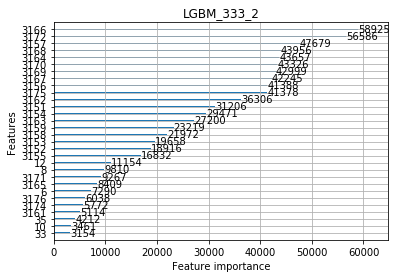

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.84156e-05	valid_0's local_loss: 2.61846
[100]	valid_0's l2: 5.2603e-05	valid_0's local_loss: 2.27798
[150]	valid_0's l2: 4.82277e-05	valid_0's local_loss: 2.17009
[200]	valid_0's l2: 4.62617e-05	valid_0's local_loss: 2.11879
[250]	valid_0's l2: 4.50643e-05	valid_0's local_loss: 2.0859
[300]	valid_0's l2: 4.41535e-05	valid_0's local_loss: 2.06181
[350]	valid_0's l2: 4.34935e-05	valid_0's local_loss: 2.0444
[400]	valid_0's l2: 4.29922e-05	valid_0's local_loss: 2.02974
[450]	valid_0's l2: 4.25938e-05	valid_0's local_loss: 2.01811
[500]	valid_0's l2: 4.22198e-05	valid_0's local_loss: 2.0085
[550]	valid_0's l2: 4.19268e-05	valid_0's local_loss: 2.00012
[600]	valid_0's l2: 4.1654e-05	valid_0's local_loss: 1.99272
[650]	valid_0's l2: 4.14212e-05	valid_0's local_loss: 1.98571
[700]	valid_0's l2: 4.12307e-05	valid_0's local_loss: 1.98085
[750]	valid_0's l2: 4.10388e-05	valid_0's local_loss

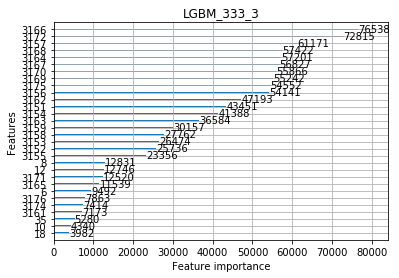

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.65451e-05	valid_0's local_loss: 2.59152
[100]	valid_0's l2: 5.10621e-05	valid_0's local_loss: 2.25865
[150]	valid_0's l2: 4.65005e-05	valid_0's local_loss: 2.14789
[200]	valid_0's l2: 4.45067e-05	valid_0's local_loss: 2.09474
[250]	valid_0's l2: 4.32393e-05	valid_0's local_loss: 2.06275
[300]	valid_0's l2: 4.24205e-05	valid_0's local_loss: 2.04103
[350]	valid_0's l2: 4.1794e-05	valid_0's local_loss: 2.02344
[400]	valid_0's l2: 4.1274e-05	valid_0's local_loss: 2.00896
[450]	valid_0's l2: 4.0857e-05	valid_0's local_loss: 1.99747
[500]	valid_0's l2: 4.05434e-05	valid_0's local_loss: 1.98918
[550]	valid_0's l2: 4.02915e-05	valid_0's local_loss: 1.98203
[600]	valid_0's l2: 4.00874e-05	valid_0's local_loss: 1.97562
[650]	valid_0's l2: 3.98983e-05	valid_0's local_loss: 1.97067
[700]	valid_0's l2: 3.97289e-05	valid_0's local_loss: 1.96603
[750]	valid_0's l2: 3.95908e-05	valid_0's local_lo

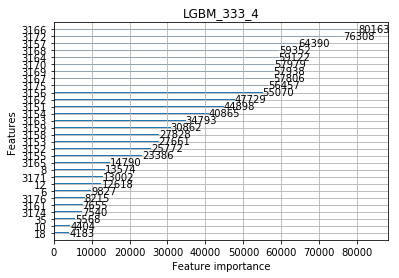

local_loss__= 1.9141603272829064
idx: 1, seed:774, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.73928e-05	valid_0's local_loss: 2.59116
[100]	valid_0's l2: 5.18012e-05	valid_0's local_loss: 2.2554
[150]	valid_0's l2: 4.71798e-05	valid_0's local_loss: 2.14666
[200]	valid_0's l2: 4.5133e-05	valid_0's local_loss: 2.09281
[250]	valid_0's l2: 4.37142e-05	valid_0's local_loss: 2.05695
[300]	valid_0's l2: 4.29059e-05	valid_0's local_loss: 2.03507
[350]	valid_0's l2: 4.22074e-05	valid_0's local_loss: 2.01499
[400]	valid_0's l2: 4.16793e-05	valid_0's local_loss: 2.00075
[450]	valid_0's l2: 4.13015e-05	valid_0's local_loss: 1.98926
[500]	valid_0's l2: 4.09166e-05	valid_0's local_loss: 1.97828
[550]	valid_0's l2: 4.05996e-05	valid_0's local_loss: 1.9693
[600]	valid_0's l2: 4.03577e-05	valid_0's local_loss: 1.963
[650]	valid_0's l2: 4.01512e-05	valid_0's local_loss: 1.95608
[700]	valid_0's l2: 3.99654e-05	valid_0's local_loss:

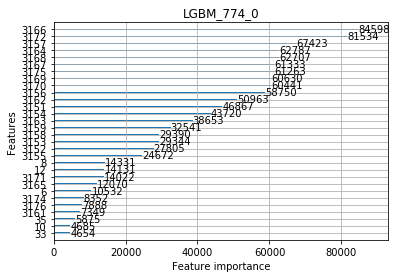

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.7387e-05	valid_0's local_loss: 2.59756
[100]	valid_0's l2: 5.15515e-05	valid_0's local_loss: 2.25494
[150]	valid_0's l2: 4.70049e-05	valid_0's local_loss: 2.14496
[200]	valid_0's l2: 4.50616e-05	valid_0's local_loss: 2.09476
[250]	valid_0's l2: 4.38816e-05	valid_0's local_loss: 2.06268
[300]	valid_0's l2: 4.30671e-05	valid_0's local_loss: 2.04143
[350]	valid_0's l2: 4.23486e-05	valid_0's local_loss: 2.0219
[400]	valid_0's l2: 4.17683e-05	valid_0's local_loss: 2.00501
[450]	valid_0's l2: 4.13339e-05	valid_0's local_loss: 1.99282
[500]	valid_0's l2: 4.09925e-05	valid_0's local_loss: 1.98315
[550]	valid_0's l2: 4.07566e-05	valid_0's local_loss: 1.97647
[600]	valid_0's l2: 4.04881e-05	valid_0's local_loss: 1.96931
[650]	valid_0's l2: 4.02672e-05	valid_0's local_loss: 1.963
[700]	valid_0's l2: 4.00919e-05	valid_0's local_loss: 1.95834
[750]	valid_0's l2: 3.99394e-05	valid_0's local_los

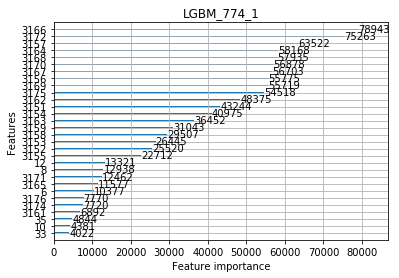

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.63485e-05	valid_0's local_loss: 2.58309
[100]	valid_0's l2: 5.17826e-05	valid_0's local_loss: 2.2594
[150]	valid_0's l2: 4.73737e-05	valid_0's local_loss: 2.14972
[200]	valid_0's l2: 4.53988e-05	valid_0's local_loss: 2.09643
[250]	valid_0's l2: 4.40736e-05	valid_0's local_loss: 2.06149
[300]	valid_0's l2: 4.33148e-05	valid_0's local_loss: 2.04057
[350]	valid_0's l2: 4.26667e-05	valid_0's local_loss: 2.02164
[400]	valid_0's l2: 4.21497e-05	valid_0's local_loss: 2.00693
[450]	valid_0's l2: 4.16956e-05	valid_0's local_loss: 1.99438
[500]	valid_0's l2: 4.13434e-05	valid_0's local_loss: 1.98487
[550]	valid_0's l2: 4.10926e-05	valid_0's local_loss: 1.97737
[600]	valid_0's l2: 4.08465e-05	valid_0's local_loss: 1.97026
[650]	valid_0's l2: 4.06184e-05	valid_0's local_loss: 1.96375
[700]	valid_0's l2: 4.04502e-05	valid_0's local_loss: 1.9593
[750]	valid_0's l2: 4.02991e-05	valid_0's local_l

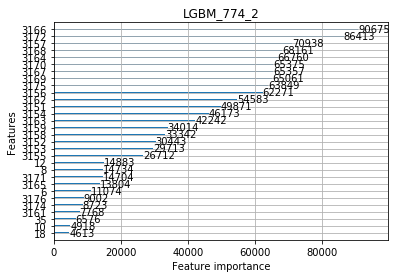

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.54314e-05	valid_0's local_loss: 2.58522
[100]	valid_0's l2: 5.10032e-05	valid_0's local_loss: 2.26727
[150]	valid_0's l2: 4.68083e-05	valid_0's local_loss: 2.16269
[200]	valid_0's l2: 4.49663e-05	valid_0's local_loss: 2.11438
[250]	valid_0's l2: 4.3725e-05	valid_0's local_loss: 2.07996
[300]	valid_0's l2: 4.28291e-05	valid_0's local_loss: 2.05612
[350]	valid_0's l2: 4.21529e-05	valid_0's local_loss: 2.0376
[400]	valid_0's l2: 4.16598e-05	valid_0's local_loss: 2.02332
[450]	valid_0's l2: 4.12078e-05	valid_0's local_loss: 2.01113
[500]	valid_0's l2: 4.08405e-05	valid_0's local_loss: 2.00053
[550]	valid_0's l2: 4.05797e-05	valid_0's local_loss: 1.993
[600]	valid_0's l2: 4.03524e-05	valid_0's local_loss: 1.98593
[650]	valid_0's l2: 4.01688e-05	valid_0's local_loss: 1.98058
[700]	valid_0's l2: 3.9962e-05	valid_0's local_loss: 1.97523
[750]	valid_0's l2: 3.98103e-05	valid_0's local_loss

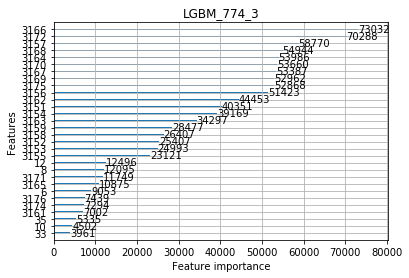

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.65372e-05	valid_0's local_loss: 2.58104
[100]	valid_0's l2: 5.11655e-05	valid_0's local_loss: 2.2443
[150]	valid_0's l2: 4.66452e-05	valid_0's local_loss: 2.13478
[200]	valid_0's l2: 4.48497e-05	valid_0's local_loss: 2.08851
[250]	valid_0's l2: 4.35458e-05	valid_0's local_loss: 2.05505
[300]	valid_0's l2: 4.26566e-05	valid_0's local_loss: 2.02969
[350]	valid_0's l2: 4.20671e-05	valid_0's local_loss: 2.01321
[400]	valid_0's l2: 4.15502e-05	valid_0's local_loss: 1.99864
[450]	valid_0's l2: 4.10948e-05	valid_0's local_loss: 1.98731
[500]	valid_0's l2: 4.07285e-05	valid_0's local_loss: 1.97728
[550]	valid_0's l2: 4.04408e-05	valid_0's local_loss: 1.96985
[600]	valid_0's l2: 4.01764e-05	valid_0's local_loss: 1.96304
[650]	valid_0's l2: 4.0007e-05	valid_0's local_loss: 1.95817
[700]	valid_0's l2: 3.98245e-05	valid_0's local_loss: 1.95332
[750]	valid_0's l2: 3.9661e-05	valid_0's local_lo

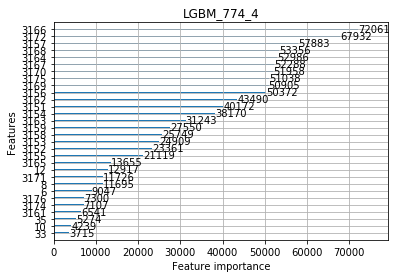

local_loss__= 1.9183962758551771
idx: 2, seed:723, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.77493e-05	valid_0's local_loss: 2.59056
[100]	valid_0's l2: 5.21634e-05	valid_0's local_loss: 2.25106
[150]	valid_0's l2: 4.77185e-05	valid_0's local_loss: 2.14146
[200]	valid_0's l2: 4.56922e-05	valid_0's local_loss: 2.08889
[250]	valid_0's l2: 4.44554e-05	valid_0's local_loss: 2.05555
[300]	valid_0's l2: 4.35676e-05	valid_0's local_loss: 2.03185
[350]	valid_0's l2: 4.28168e-05	valid_0's local_loss: 2.0119
[400]	valid_0's l2: 4.22601e-05	valid_0's local_loss: 1.99592
[450]	valid_0's l2: 4.18341e-05	valid_0's local_loss: 1.98489
[500]	valid_0's l2: 4.1473e-05	valid_0's local_loss: 1.97546
[550]	valid_0's l2: 4.11797e-05	valid_0's local_loss: 1.96745
[600]	valid_0's l2: 4.09065e-05	valid_0's local_loss: 1.95928
[650]	valid_0's l2: 4.07336e-05	valid_0's local_loss: 1.95371
[700]	valid_0's l2: 4.05801e-05	valid_0's local_lo

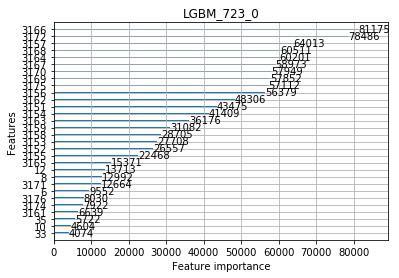

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.50714e-05	valid_0's local_loss: 2.56006
[100]	valid_0's l2: 4.98098e-05	valid_0's local_loss: 2.22553
[150]	valid_0's l2: 4.55348e-05	valid_0's local_loss: 2.11934
[200]	valid_0's l2: 4.36177e-05	valid_0's local_loss: 2.06992
[250]	valid_0's l2: 4.24455e-05	valid_0's local_loss: 2.0388
[300]	valid_0's l2: 4.16175e-05	valid_0's local_loss: 2.01618
[350]	valid_0's l2: 4.09227e-05	valid_0's local_loss: 1.99693
[400]	valid_0's l2: 4.04231e-05	valid_0's local_loss: 1.98401
[450]	valid_0's l2: 4.00423e-05	valid_0's local_loss: 1.97334
[500]	valid_0's l2: 3.97117e-05	valid_0's local_loss: 1.96447
[550]	valid_0's l2: 3.94126e-05	valid_0's local_loss: 1.95566
[600]	valid_0's l2: 3.91594e-05	valid_0's local_loss: 1.94857
[650]	valid_0's l2: 3.89298e-05	valid_0's local_loss: 1.94196
[700]	valid_0's l2: 3.87587e-05	valid_0's local_loss: 1.93711
[750]	valid_0's l2: 3.86004e-05	valid_0's local_

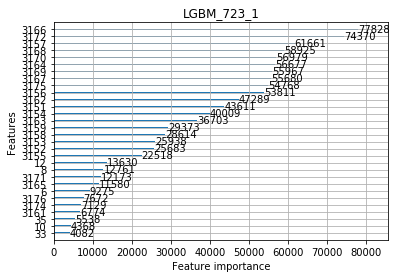

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.76113e-05	valid_0's local_loss: 2.61087
[100]	valid_0's l2: 5.18978e-05	valid_0's local_loss: 2.27042
[150]	valid_0's l2: 4.71618e-05	valid_0's local_loss: 2.15426
[200]	valid_0's l2: 4.52594e-05	valid_0's local_loss: 2.10637
[250]	valid_0's l2: 4.39793e-05	valid_0's local_loss: 2.07224
[300]	valid_0's l2: 4.31009e-05	valid_0's local_loss: 2.04719
[350]	valid_0's l2: 4.24484e-05	valid_0's local_loss: 2.02931
[400]	valid_0's l2: 4.18811e-05	valid_0's local_loss: 2.01389
[450]	valid_0's l2: 4.14685e-05	valid_0's local_loss: 2.00251
[500]	valid_0's l2: 4.1058e-05	valid_0's local_loss: 1.99125
[550]	valid_0's l2: 4.07688e-05	valid_0's local_loss: 1.98431
[600]	valid_0's l2: 4.04803e-05	valid_0's local_loss: 1.97581
[650]	valid_0's l2: 4.02775e-05	valid_0's local_loss: 1.97041
[700]	valid_0's l2: 4.0085e-05	valid_0's local_loss: 1.96523
[750]	valid_0's l2: 3.99463e-05	valid_0's local_l

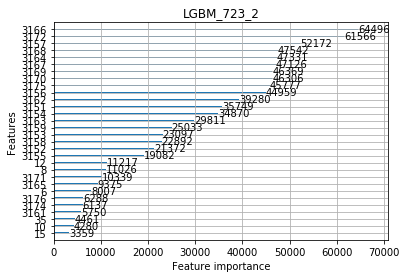

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.49124e-05	valid_0's local_loss: 2.5719
[100]	valid_0's l2: 4.99861e-05	valid_0's local_loss: 2.23759
[150]	valid_0's l2: 4.56709e-05	valid_0's local_loss: 2.12961
[200]	valid_0's l2: 4.36371e-05	valid_0's local_loss: 2.07596
[250]	valid_0's l2: 4.24567e-05	valid_0's local_loss: 2.04437
[300]	valid_0's l2: 4.16069e-05	valid_0's local_loss: 2.02057
[350]	valid_0's l2: 4.09564e-05	valid_0's local_loss: 2.00171
[400]	valid_0's l2: 4.0463e-05	valid_0's local_loss: 1.98699
[450]	valid_0's l2: 4.00379e-05	valid_0's local_loss: 1.97461
[500]	valid_0's l2: 3.96547e-05	valid_0's local_loss: 1.96342
[550]	valid_0's l2: 3.93376e-05	valid_0's local_loss: 1.95487
[600]	valid_0's l2: 3.90987e-05	valid_0's local_loss: 1.94805
[650]	valid_0's l2: 3.88803e-05	valid_0's local_loss: 1.94163
[700]	valid_0's l2: 3.87326e-05	valid_0's local_loss: 1.93724
[750]	valid_0's l2: 3.85908e-05	valid_0's local_l

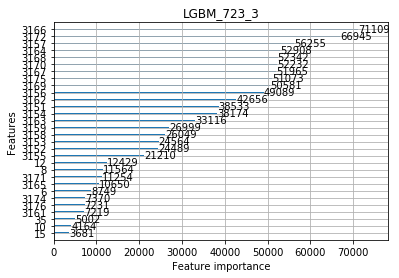

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 6.81802e-05	valid_0's local_loss: 2.61054
[100]	valid_0's l2: 5.2522e-05	valid_0's local_loss: 2.27815
[150]	valid_0's l2: 4.79204e-05	valid_0's local_loss: 2.1668
[200]	valid_0's l2: 4.57765e-05	valid_0's local_loss: 2.11361
[250]	valid_0's l2: 4.45457e-05	valid_0's local_loss: 2.07936
[300]	valid_0's l2: 4.37457e-05	valid_0's local_loss: 2.05676
[350]	valid_0's l2: 4.30886e-05	valid_0's local_loss: 2.03956
[400]	valid_0's l2: 4.25527e-05	valid_0's local_loss: 2.02485
[450]	valid_0's l2: 4.21815e-05	valid_0's local_loss: 2.01351
[500]	valid_0's l2: 4.18389e-05	valid_0's local_loss: 2.00421
[550]	valid_0's l2: 4.15426e-05	valid_0's local_loss: 1.9956
[600]	valid_0's l2: 4.12904e-05	valid_0's local_loss: 1.98862
[650]	valid_0's l2: 4.10274e-05	valid_0's local_loss: 1.98169
[700]	valid_0's l2: 4.08558e-05	valid_0's local_loss: 1.97722
[750]	valid_0's l2: 4.07141e-05	valid_0's local_lo

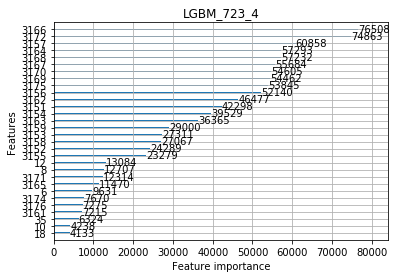

local_loss__= 1.9127770723623536
local_loss__= 1.8466858022627872


In [8]:
losses=train_single_LGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\Models/Model_p2',
                 seed_num=3, n_splits=5,lr=0.07)

In [9]:
import gc
del trainX,trainy
gc.collect()

25442

In [10]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p3')

trainX shape: (79267, 3126)
idx: 0, seed:432, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000115682	valid_0's local_loss: 38.1151
[100]	valid_0's l2: 7.05845e-05	valid_0's local_loss: 32.2083
[150]	valid_0's l2: 6.1222e-05	valid_0's local_loss: 30.1801
[200]	valid_0's l2: 5.75267e-05	valid_0's local_loss: 29.3353
[250]	valid_0's l2: 5.57376e-05	valid_0's local_loss: 28.8469
[300]	valid_0's l2: 5.44177e-05	valid_0's local_loss: 28.4966
[350]	valid_0's l2: 5.34387e-05	valid_0's local_loss: 28.2297
[400]	valid_0's l2: 5.25893e-05	valid_0's local_loss: 28.0114
[450]	valid_0's l2: 5.19202e-05	valid_0's local_loss: 27.8968
[500]	valid_0's l2: 5.13483e-05	valid_0's local_loss: 27.7048
[550]	valid_0's l2: 5.083e-05	valid_0's local_loss: 27.5825
[600]	valid_0's l2: 5.03789e-05	valid_0's local_loss: 27.4546
[650]	valid_0's l2: 5.00301e-05	valid_0's local_loss: 27.3901
[700]	valid_0's l2: 4.96849e-05	valid_0's local_loss: 27

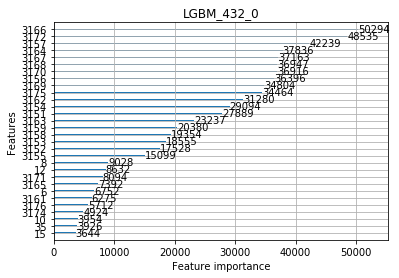

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000119826	valid_0's local_loss: 38.4571
[100]	valid_0's l2: 7.26387e-05	valid_0's local_loss: 32.4383
[150]	valid_0's l2: 6.31169e-05	valid_0's local_loss: 30.7027
[200]	valid_0's l2: 5.93041e-05	valid_0's local_loss: 29.9119
[250]	valid_0's l2: 5.71474e-05	valid_0's local_loss: 29.4112
[300]	valid_0's l2: 5.57646e-05	valid_0's local_loss: 29.0799
[350]	valid_0's l2: 5.46989e-05	valid_0's local_loss: 28.8351
[400]	valid_0's l2: 5.38263e-05	valid_0's local_loss: 28.6312
[450]	valid_0's l2: 5.30668e-05	valid_0's local_loss: 28.4451
[500]	valid_0's l2: 5.24883e-05	valid_0's local_loss: 28.2776
[550]	valid_0's l2: 5.20216e-05	valid_0's local_loss: 28.1608
[600]	valid_0's l2: 5.16176e-05	valid_0's local_loss: 28.0221
[650]	valid_0's l2: 5.1242e-05	valid_0's local_loss: 27.9275
[700]	valid_0's l2: 5.09393e-05	valid_0's local_loss: 27.8507
[750]	valid_0's l2: 5.0624e-05	valid_0's local_l

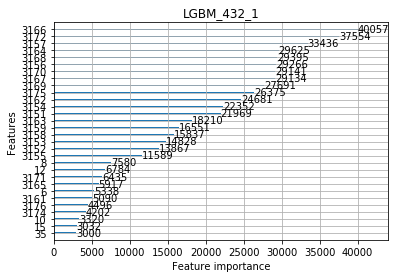

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000118536	valid_0's local_loss: 38.2213
[100]	valid_0's l2: 7.25727e-05	valid_0's local_loss: 32.2617
[150]	valid_0's l2: 6.308e-05	valid_0's local_loss: 30.4339
[200]	valid_0's l2: 5.90922e-05	valid_0's local_loss: 29.5932
[250]	valid_0's l2: 5.69933e-05	valid_0's local_loss: 29.1138
[300]	valid_0's l2: 5.55414e-05	valid_0's local_loss: 28.7482
[350]	valid_0's l2: 5.43944e-05	valid_0's local_loss: 28.4432
[400]	valid_0's l2: 5.354e-05	valid_0's local_loss: 28.2691
[450]	valid_0's l2: 5.28305e-05	valid_0's local_loss: 28.0687
[500]	valid_0's l2: 5.22095e-05	valid_0's local_loss: 27.8991
[550]	valid_0's l2: 5.17155e-05	valid_0's local_loss: 27.7503
[600]	valid_0's l2: 5.1261e-05	valid_0's local_loss: 27.6222
[650]	valid_0's l2: 5.08868e-05	valid_0's local_loss: 27.5633
[700]	valid_0's l2: 5.05415e-05	valid_0's local_loss: 27.4707
[750]	valid_0's l2: 5.0238e-05	valid_0's local_loss:

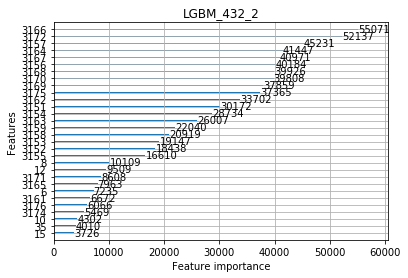

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000117649	valid_0's local_loss: 38.744
[100]	valid_0's l2: 7.21964e-05	valid_0's local_loss: 32.8208
[150]	valid_0's l2: 6.2935e-05	valid_0's local_loss: 31.0074
[200]	valid_0's l2: 5.90325e-05	valid_0's local_loss: 30.1651
[250]	valid_0's l2: 5.69845e-05	valid_0's local_loss: 29.7166
[300]	valid_0's l2: 5.55849e-05	valid_0's local_loss: 29.3819
[350]	valid_0's l2: 5.45975e-05	valid_0's local_loss: 29.1435
[400]	valid_0's l2: 5.37922e-05	valid_0's local_loss: 28.9132
[450]	valid_0's l2: 5.30323e-05	valid_0's local_loss: 28.7002
[500]	valid_0's l2: 5.24339e-05	valid_0's local_loss: 28.4974
[550]	valid_0's l2: 5.19095e-05	valid_0's local_loss: 28.3272
[600]	valid_0's l2: 5.14664e-05	valid_0's local_loss: 28.2138
[650]	valid_0's l2: 5.10433e-05	valid_0's local_loss: 28.0953
[700]	valid_0's l2: 5.06588e-05	valid_0's local_loss: 28.002
[750]	valid_0's l2: 5.03531e-05	valid_0's local_lo

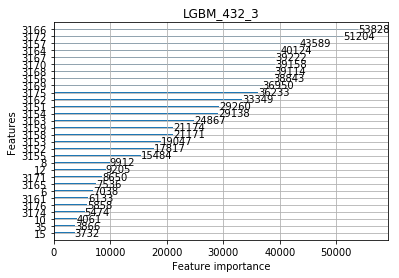

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000117406	valid_0's local_loss: 37.5932
[100]	valid_0's l2: 7.10907e-05	valid_0's local_loss: 31.3058
[150]	valid_0's l2: 6.18066e-05	valid_0's local_loss: 29.6013
[200]	valid_0's l2: 5.77957e-05	valid_0's local_loss: 28.7342
[250]	valid_0's l2: 5.58044e-05	valid_0's local_loss: 28.2378
[300]	valid_0's l2: 5.43373e-05	valid_0's local_loss: 27.892
[350]	valid_0's l2: 5.31951e-05	valid_0's local_loss: 27.6662
[400]	valid_0's l2: 5.23401e-05	valid_0's local_loss: 27.4876
[450]	valid_0's l2: 5.16425e-05	valid_0's local_loss: 27.2985
[500]	valid_0's l2: 5.10989e-05	valid_0's local_loss: 27.157
[550]	valid_0's l2: 5.05994e-05	valid_0's local_loss: 27.0228
[600]	valid_0's l2: 5.01613e-05	valid_0's local_loss: 26.8929
[650]	valid_0's l2: 4.9764e-05	valid_0's local_loss: 26.7951
[700]	valid_0's l2: 4.94026e-05	valid_0's local_loss: 26.709
[750]	valid_0's l2: 4.90572e-05	valid_0's local_los

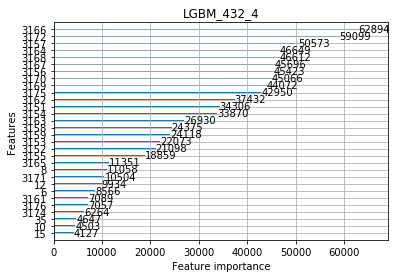

local_loss__= 26.509384147213495
idx: 1, seed:999, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000117943	valid_0's local_loss: 38.3214
[100]	valid_0's l2: 7.20957e-05	valid_0's local_loss: 32.4875
[150]	valid_0's l2: 6.2478e-05	valid_0's local_loss: 30.8025
[200]	valid_0's l2: 5.85108e-05	valid_0's local_loss: 29.9961
[250]	valid_0's l2: 5.63629e-05	valid_0's local_loss: 29.484
[300]	valid_0's l2: 5.50177e-05	valid_0's local_loss: 29.1132
[350]	valid_0's l2: 5.39574e-05	valid_0's local_loss: 28.8882
[400]	valid_0's l2: 5.31258e-05	valid_0's local_loss: 28.6783
[450]	valid_0's l2: 5.23461e-05	valid_0's local_loss: 28.4819
[500]	valid_0's l2: 5.17413e-05	valid_0's local_loss: 28.2861
[550]	valid_0's l2: 5.12652e-05	valid_0's local_loss: 28.1495
[600]	valid_0's l2: 5.08281e-05	valid_0's local_loss: 28.0539
[650]	valid_0's l2: 5.05044e-05	valid_0's local_loss: 27.9419
[700]	valid_0's l2: 5.0141e-05	valid_0's local_los

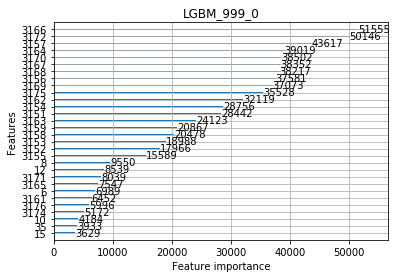

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000116076	valid_0's local_loss: 38.1155
[100]	valid_0's l2: 7.26717e-05	valid_0's local_loss: 32.326
[150]	valid_0's l2: 6.36751e-05	valid_0's local_loss: 30.601
[200]	valid_0's l2: 5.98894e-05	valid_0's local_loss: 29.7735
[250]	valid_0's l2: 5.79847e-05	valid_0's local_loss: 29.3599
[300]	valid_0's l2: 5.67393e-05	valid_0's local_loss: 29.11
[350]	valid_0's l2: 5.56906e-05	valid_0's local_loss: 28.8254
[400]	valid_0's l2: 5.47596e-05	valid_0's local_loss: 28.5687
[450]	valid_0's l2: 5.40288e-05	valid_0's local_loss: 28.3976
[500]	valid_0's l2: 5.34027e-05	valid_0's local_loss: 28.2358
[550]	valid_0's l2: 5.28588e-05	valid_0's local_loss: 28.0508
[600]	valid_0's l2: 5.23888e-05	valid_0's local_loss: 27.8981
[650]	valid_0's l2: 5.19919e-05	valid_0's local_loss: 27.7707
[700]	valid_0's l2: 5.1641e-05	valid_0's local_loss: 27.6748
[750]	valid_0's l2: 5.13206e-05	valid_0's local_loss

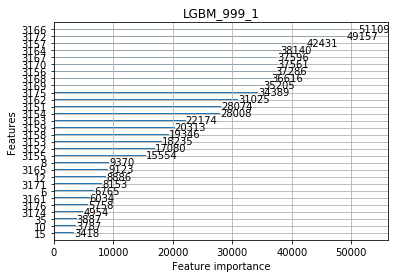

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000117737	valid_0's local_loss: 38.4416
[100]	valid_0's l2: 7.23382e-05	valid_0's local_loss: 32.2831
[150]	valid_0's l2: 6.3035e-05	valid_0's local_loss: 30.5146
[200]	valid_0's l2: 5.91701e-05	valid_0's local_loss: 29.7068
[250]	valid_0's l2: 5.69611e-05	valid_0's local_loss: 29.2109
[300]	valid_0's l2: 5.56247e-05	valid_0's local_loss: 28.8897
[350]	valid_0's l2: 5.45753e-05	valid_0's local_loss: 28.5743
[400]	valid_0's l2: 5.37413e-05	valid_0's local_loss: 28.3639
[450]	valid_0's l2: 5.30544e-05	valid_0's local_loss: 28.1749
[500]	valid_0's l2: 5.23525e-05	valid_0's local_loss: 27.9858
[550]	valid_0's l2: 5.18198e-05	valid_0's local_loss: 27.8512
[600]	valid_0's l2: 5.13487e-05	valid_0's local_loss: 27.7006
[650]	valid_0's l2: 5.09278e-05	valid_0's local_loss: 27.5917
[700]	valid_0's l2: 5.06071e-05	valid_0's local_loss: 27.5351
[750]	valid_0's l2: 5.03397e-05	valid_0's local_

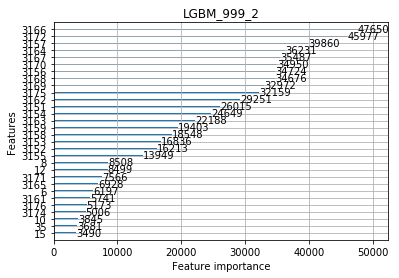

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000118204	valid_0's local_loss: 37.582
[100]	valid_0's l2: 7.11779e-05	valid_0's local_loss: 31.6898
[150]	valid_0's l2: 6.18185e-05	valid_0's local_loss: 29.953
[200]	valid_0's l2: 5.78225e-05	valid_0's local_loss: 29.0672
[250]	valid_0's l2: 5.58182e-05	valid_0's local_loss: 28.5804
[300]	valid_0's l2: 5.44751e-05	valid_0's local_loss: 28.2117
[350]	valid_0's l2: 5.34572e-05	valid_0's local_loss: 27.9909
[400]	valid_0's l2: 5.25981e-05	valid_0's local_loss: 27.7722
[450]	valid_0's l2: 5.18827e-05	valid_0's local_loss: 27.5706
[500]	valid_0's l2: 5.13166e-05	valid_0's local_loss: 27.4258
[550]	valid_0's l2: 5.08247e-05	valid_0's local_loss: 27.284
[600]	valid_0's l2: 5.03735e-05	valid_0's local_loss: 27.1729
[650]	valid_0's l2: 4.99518e-05	valid_0's local_loss: 27.0303
[700]	valid_0's l2: 4.9632e-05	valid_0's local_loss: 26.9435
[750]	valid_0's l2: 4.93832e-05	valid_0's local_los

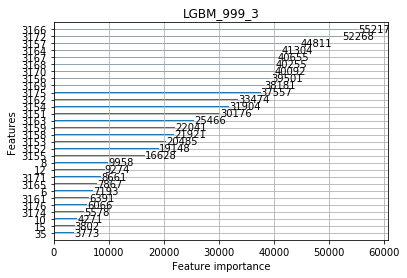

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000122595	valid_0's local_loss: 38.3439
[100]	valid_0's l2: 7.41704e-05	valid_0's local_loss: 32.2617
[150]	valid_0's l2: 6.43835e-05	valid_0's local_loss: 30.3793
[200]	valid_0's l2: 6.05132e-05	valid_0's local_loss: 29.4984
[250]	valid_0's l2: 5.84004e-05	valid_0's local_loss: 28.9451
[300]	valid_0's l2: 5.69564e-05	valid_0's local_loss: 28.6044
[350]	valid_0's l2: 5.59875e-05	valid_0's local_loss: 28.334
[400]	valid_0's l2: 5.50571e-05	valid_0's local_loss: 28.1079
[450]	valid_0's l2: 5.4338e-05	valid_0's local_loss: 27.8997
[500]	valid_0's l2: 5.36377e-05	valid_0's local_loss: 27.7399
[550]	valid_0's l2: 5.31615e-05	valid_0's local_loss: 27.6002
[600]	valid_0's l2: 5.26602e-05	valid_0's local_loss: 27.4912
[650]	valid_0's l2: 5.22504e-05	valid_0's local_loss: 27.3863
[700]	valid_0's l2: 5.19026e-05	valid_0's local_loss: 27.2904
[750]	valid_0's l2: 5.16232e-05	valid_0's local_l

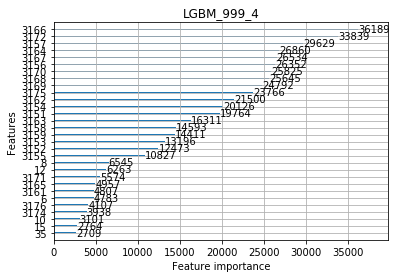

local_loss__= 26.478924715868462
idx: 2, seed:135, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000119459	valid_0's local_loss: 38.3765
[100]	valid_0's l2: 7.24213e-05	valid_0's local_loss: 32.2918
[150]	valid_0's l2: 6.2943e-05	valid_0's local_loss: 30.4737
[200]	valid_0's l2: 5.91283e-05	valid_0's local_loss: 29.678
[250]	valid_0's l2: 5.70337e-05	valid_0's local_loss: 29.1795
[300]	valid_0's l2: 5.55014e-05	valid_0's local_loss: 28.7758
[350]	valid_0's l2: 5.4464e-05	valid_0's local_loss: 28.4914
[400]	valid_0's l2: 5.3618e-05	valid_0's local_loss: 28.2722
[450]	valid_0's l2: 5.28497e-05	valid_0's local_loss: 28.0865
[500]	valid_0's l2: 5.23121e-05	valid_0's local_loss: 27.9371
[550]	valid_0's l2: 5.17708e-05	valid_0's local_loss: 27.795
[600]	valid_0's l2: 5.1337e-05	valid_0's local_loss: 27.6627
[650]	valid_0's l2: 5.09465e-05	valid_0's local_loss: 27.5256
[700]	valid_0's l2: 5.06683e-05	valid_0's local_loss: 

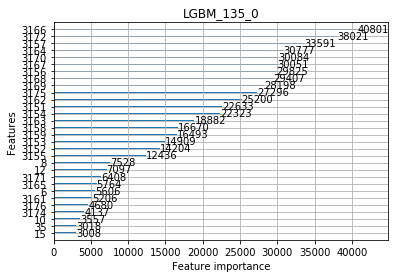

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000118986	valid_0's local_loss: 37.6916
[100]	valid_0's l2: 7.31469e-05	valid_0's local_loss: 31.9243
[150]	valid_0's l2: 6.34782e-05	valid_0's local_loss: 30.2367
[200]	valid_0's l2: 5.98398e-05	valid_0's local_loss: 29.497
[250]	valid_0's l2: 5.77308e-05	valid_0's local_loss: 29.0678
[300]	valid_0's l2: 5.63035e-05	valid_0's local_loss: 28.6828
[350]	valid_0's l2: 5.53088e-05	valid_0's local_loss: 28.4023
[400]	valid_0's l2: 5.43356e-05	valid_0's local_loss: 28.157
[450]	valid_0's l2: 5.3597e-05	valid_0's local_loss: 27.9797
[500]	valid_0's l2: 5.29794e-05	valid_0's local_loss: 27.8073
[550]	valid_0's l2: 5.24884e-05	valid_0's local_loss: 27.7245
[600]	valid_0's l2: 5.20292e-05	valid_0's local_loss: 27.5866
[650]	valid_0's l2: 5.16693e-05	valid_0's local_loss: 27.4528
[700]	valid_0's l2: 5.12995e-05	valid_0's local_loss: 27.3233
[750]	valid_0's l2: 5.10072e-05	valid_0's local_lo

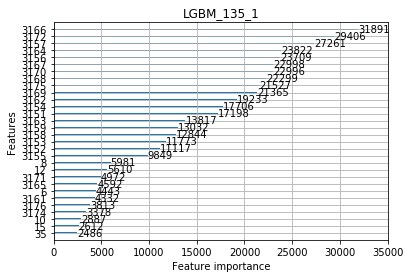

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000116774	valid_0's local_loss: 38.2202
[100]	valid_0's l2: 7.23898e-05	valid_0's local_loss: 32.3967
[150]	valid_0's l2: 6.29463e-05	valid_0's local_loss: 30.5508
[200]	valid_0's l2: 5.90678e-05	valid_0's local_loss: 29.6622
[250]	valid_0's l2: 5.71863e-05	valid_0's local_loss: 29.2276
[300]	valid_0's l2: 5.57956e-05	valid_0's local_loss: 28.892
[350]	valid_0's l2: 5.48579e-05	valid_0's local_loss: 28.6428
[400]	valid_0's l2: 5.39857e-05	valid_0's local_loss: 28.4861
[450]	valid_0's l2: 5.33313e-05	valid_0's local_loss: 28.3062
[500]	valid_0's l2: 5.26919e-05	valid_0's local_loss: 28.1399
[550]	valid_0's l2: 5.22209e-05	valid_0's local_loss: 28.0058
[600]	valid_0's l2: 5.18137e-05	valid_0's local_loss: 27.9013
[650]	valid_0's l2: 5.13814e-05	valid_0's local_loss: 27.8134
[700]	valid_0's l2: 5.10275e-05	valid_0's local_loss: 27.7289
[750]	valid_0's l2: 5.07295e-05	valid_0's local_

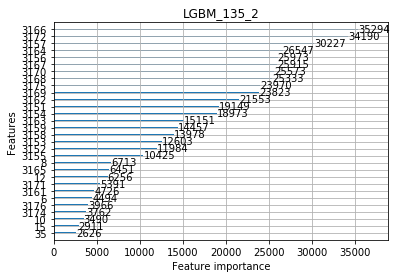

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000119449	valid_0's local_loss: 38.1384
[100]	valid_0's l2: 7.25269e-05	valid_0's local_loss: 32.1054
[150]	valid_0's l2: 6.26456e-05	valid_0's local_loss: 30.1827
[200]	valid_0's l2: 5.86276e-05	valid_0's local_loss: 29.3409
[250]	valid_0's l2: 5.66163e-05	valid_0's local_loss: 28.866
[300]	valid_0's l2: 5.52229e-05	valid_0's local_loss: 28.4887
[350]	valid_0's l2: 5.4296e-05	valid_0's local_loss: 28.2145
[400]	valid_0's l2: 5.34791e-05	valid_0's local_loss: 27.9906
[450]	valid_0's l2: 5.27019e-05	valid_0's local_loss: 27.7953
[500]	valid_0's l2: 5.21351e-05	valid_0's local_loss: 27.6664
[550]	valid_0's l2: 5.15699e-05	valid_0's local_loss: 27.5324
[600]	valid_0's l2: 5.11132e-05	valid_0's local_loss: 27.3951
[650]	valid_0's l2: 5.07438e-05	valid_0's local_loss: 27.3173
[700]	valid_0's l2: 5.03719e-05	valid_0's local_loss: 27.22
[750]	valid_0's l2: 5.00807e-05	valid_0's local_los

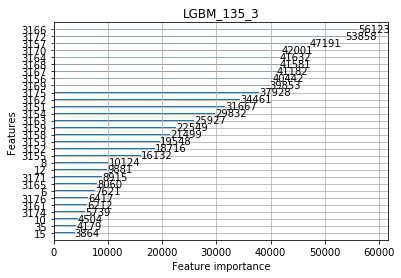

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 0.000116557	valid_0's local_loss: 38.8848
[100]	valid_0's l2: 7.03034e-05	valid_0's local_loss: 32.5983
[150]	valid_0's l2: 6.10041e-05	valid_0's local_loss: 30.7812
[200]	valid_0's l2: 5.72293e-05	valid_0's local_loss: 29.8463
[250]	valid_0's l2: 5.53836e-05	valid_0's local_loss: 29.3551
[300]	valid_0's l2: 5.41592e-05	valid_0's local_loss: 28.9932
[350]	valid_0's l2: 5.30971e-05	valid_0's local_loss: 28.7003
[400]	valid_0's l2: 5.22025e-05	valid_0's local_loss: 28.4438
[450]	valid_0's l2: 5.15599e-05	valid_0's local_loss: 28.2676
[500]	valid_0's l2: 5.09908e-05	valid_0's local_loss: 28.0853
[550]	valid_0's l2: 5.05002e-05	valid_0's local_loss: 27.9176
[600]	valid_0's l2: 5.00686e-05	valid_0's local_loss: 27.7852
[650]	valid_0's l2: 4.97305e-05	valid_0's local_loss: 27.6769
[700]	valid_0's l2: 4.93916e-05	valid_0's local_loss: 27.5854
[750]	valid_0's l2: 4.9082e-05	valid_0's local_

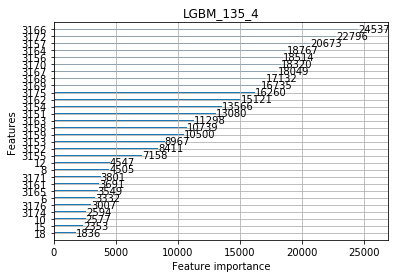

local_loss__= 26.583831730875364
local_loss__= 25.76001349491944


In [11]:
losses=train_single_LGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\Models/Model_p3',
                 seed_num=3, n_splits=5,lr=0.05)

In [12]:
import gc
del trainX,trainy
gc.collect()

12460

In [13]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p4')

trainX shape: (79267, 3126)
idx: 0, seed:354, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.95481e-06	valid_0's local_loss: 1.77513
[100]	valid_0's l2: 1.67571e-06	valid_0's local_loss: 0.58668
[150]	valid_0's l2: 1.23006e-06	valid_0's local_loss: 0.477609
[200]	valid_0's l2: 1.10061e-06	valid_0's local_loss: 0.441202
[250]	valid_0's l2: 1.04765e-06	valid_0's local_loss: 0.42357
[300]	valid_0's l2: 1.01348e-06	valid_0's local_loss: 0.41222
[350]	valid_0's l2: 9.93949e-07	valid_0's local_loss: 0.404353
[400]	valid_0's l2: 9.80341e-07	valid_0's local_loss: 0.399163
[450]	valid_0's l2: 9.71282e-07	valid_0's local_loss: 0.395727
[500]	valid_0's l2: 9.63406e-07	valid_0's local_loss: 0.392802
[550]	valid_0's l2: 9.58113e-07	valid_0's local_loss: 0.390374
[600]	valid_0's l2: 9.50797e-07	valid_0's local_loss: 0.387932
[650]	valid_0's l2: 9.4641e-07	valid_0's local_loss: 0.386179
[700]	valid_0's l2: 9.42707e-07	valid_0's loc

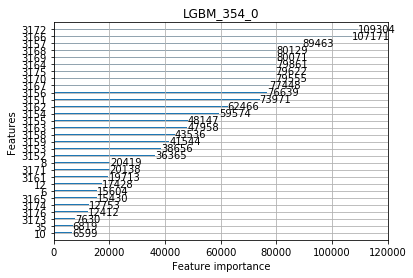

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.86685e-06	valid_0's local_loss: 1.75055
[100]	valid_0's l2: 1.57382e-06	valid_0's local_loss: 0.584999
[150]	valid_0's l2: 1.06715e-06	valid_0's local_loss: 0.473424
[200]	valid_0's l2: 9.17042e-07	valid_0's local_loss: 0.436039
[250]	valid_0's l2: 8.44327e-07	valid_0's local_loss: 0.416265
[300]	valid_0's l2: 8.01252e-07	valid_0's local_loss: 0.403547
[350]	valid_0's l2: 7.74668e-07	valid_0's local_loss: 0.39546
[400]	valid_0's l2: 7.56816e-07	valid_0's local_loss: 0.389755
[450]	valid_0's l2: 7.43695e-07	valid_0's local_loss: 0.385251
[500]	valid_0's l2: 7.34574e-07	valid_0's local_loss: 0.3824
[550]	valid_0's l2: 7.2729e-07	valid_0's local_loss: 0.379698
[600]	valid_0's l2: 7.2118e-07	valid_0's local_loss: 0.377512
[650]	valid_0's l2: 7.16295e-07	valid_0's local_loss: 0.37536
[700]	valid_0's l2: 7.12538e-07	valid_0's local_loss: 0.373995
[750]	valid_0's l2: 7.08632e-07	valid_0'

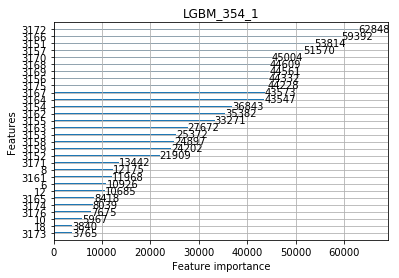

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.59788e-06	valid_0's local_loss: 1.73813
[100]	valid_0's l2: 1.52291e-06	valid_0's local_loss: 0.58703
[150]	valid_0's l2: 1.10357e-06	valid_0's local_loss: 0.481378
[200]	valid_0's l2: 9.74679e-07	valid_0's local_loss: 0.444622
[250]	valid_0's l2: 9.09871e-07	valid_0's local_loss: 0.424826
[300]	valid_0's l2: 8.71076e-07	valid_0's local_loss: 0.412036
[350]	valid_0's l2: 8.4724e-07	valid_0's local_loss: 0.403953
[400]	valid_0's l2: 8.3171e-07	valid_0's local_loss: 0.398151
[450]	valid_0's l2: 8.20213e-07	valid_0's local_loss: 0.393676
[500]	valid_0's l2: 8.12413e-07	valid_0's local_loss: 0.390727
[550]	valid_0's l2: 8.07185e-07	valid_0's local_loss: 0.388318
[600]	valid_0's l2: 8.01766e-07	valid_0's local_loss: 0.386006
[650]	valid_0's l2: 7.97143e-07	valid_0's local_loss: 0.383965
[700]	valid_0's l2: 7.93812e-07	valid_0's local_loss: 0.382486
[750]	valid_0's l2: 7.90789e-07	valid

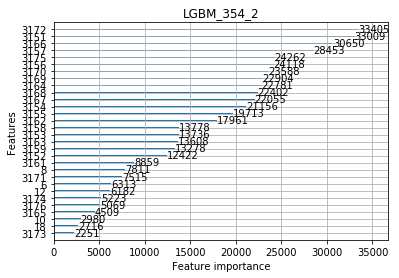

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.02563e-05	valid_0's local_loss: 1.77526
[100]	valid_0's l2: 1.7262e-06	valid_0's local_loss: 0.590235
[150]	valid_0's l2: 1.20487e-06	valid_0's local_loss: 0.478558
[200]	valid_0's l2: 1.05734e-06	valid_0's local_loss: 0.441031
[250]	valid_0's l2: 9.90768e-07	valid_0's local_loss: 0.421604
[300]	valid_0's l2: 9.54202e-07	valid_0's local_loss: 0.410441
[350]	valid_0's l2: 9.32918e-07	valid_0's local_loss: 0.402996
[400]	valid_0's l2: 9.20078e-07	valid_0's local_loss: 0.398517
[450]	valid_0's l2: 9.09475e-07	valid_0's local_loss: 0.394661
[500]	valid_0's l2: 8.99596e-07	valid_0's local_loss: 0.391155
[550]	valid_0's l2: 8.91297e-07	valid_0's local_loss: 0.388576
[600]	valid_0's l2: 8.84354e-07	valid_0's local_loss: 0.386479
[650]	valid_0's l2: 8.80381e-07	valid_0's local_loss: 0.384884
[700]	valid_0's l2: 8.73831e-07	valid_0's local_loss: 0.383123
[750]	valid_0's l2: 8.6958e-07	vali

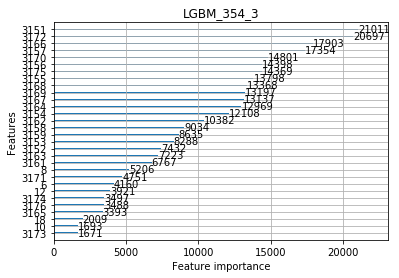

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.00212e-05	valid_0's local_loss: 1.77904
[100]	valid_0's l2: 1.63719e-06	valid_0's local_loss: 0.601418
[150]	valid_0's l2: 1.12074e-06	valid_0's local_loss: 0.483007
[200]	valid_0's l2: 9.69791e-07	valid_0's local_loss: 0.441695
[250]	valid_0's l2: 8.99742e-07	valid_0's local_loss: 0.421356
[300]	valid_0's l2: 8.61223e-07	valid_0's local_loss: 0.408821
[350]	valid_0's l2: 8.38074e-07	valid_0's local_loss: 0.400818
[400]	valid_0's l2: 8.22297e-07	valid_0's local_loss: 0.39507
[450]	valid_0's l2: 8.12223e-07	valid_0's local_loss: 0.390707
[500]	valid_0's l2: 8.04465e-07	valid_0's local_loss: 0.387547
[550]	valid_0's l2: 7.97524e-07	valid_0's local_loss: 0.384586
[600]	valid_0's l2: 7.92591e-07	valid_0's local_loss: 0.382366
[650]	valid_0's l2: 7.8711e-07	valid_0's local_loss: 0.380342
[700]	valid_0's l2: 7.8294e-07	valid_0's local_loss: 0.378595
[750]	valid_0's l2: 7.79615e-07	valid

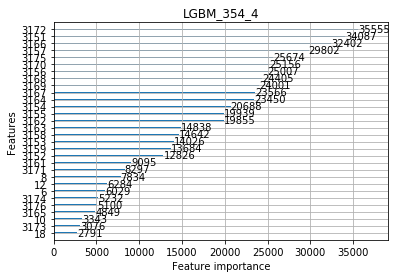

local_loss__= 0.3672249554196592
idx: 1, seed:948, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.00692e-05	valid_0's local_loss: 1.78282
[100]	valid_0's l2: 1.57394e-06	valid_0's local_loss: 0.596561
[150]	valid_0's l2: 1.10603e-06	valid_0's local_loss: 0.485813
[200]	valid_0's l2: 9.69562e-07	valid_0's local_loss: 0.44875
[250]	valid_0's l2: 9.06248e-07	valid_0's local_loss: 0.429514
[300]	valid_0's l2: 8.69837e-07	valid_0's local_loss: 0.417755
[350]	valid_0's l2: 8.45738e-07	valid_0's local_loss: 0.409483
[400]	valid_0's l2: 8.2954e-07	valid_0's local_loss: 0.403742
[450]	valid_0's l2: 8.17017e-07	valid_0's local_loss: 0.399523
[500]	valid_0's l2: 8.06981e-07	valid_0's local_loss: 0.396255
[550]	valid_0's l2: 7.99188e-07	valid_0's local_loss: 0.39336
[600]	valid_0's l2: 7.91931e-07	valid_0's local_loss: 0.390789
[650]	valid_0's l2: 7.87307e-07	valid_0's local_loss: 0.388789
[700]	valid_0's l2: 7.82531e-07	valid_0

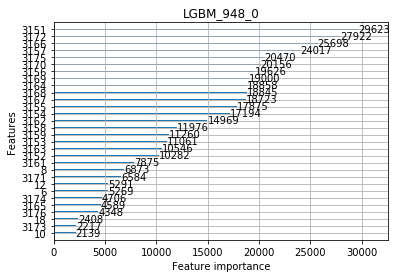

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.98832e-06	valid_0's local_loss: 1.76651
[100]	valid_0's l2: 1.72564e-06	valid_0's local_loss: 0.590283
[150]	valid_0's l2: 1.27058e-06	valid_0's local_loss: 0.478384
[200]	valid_0's l2: 1.13056e-06	valid_0's local_loss: 0.439623
[250]	valid_0's l2: 1.06463e-06	valid_0's local_loss: 0.420167
[300]	valid_0's l2: 1.02584e-06	valid_0's local_loss: 0.407873
[350]	valid_0's l2: 1.00164e-06	valid_0's local_loss: 0.399829
[400]	valid_0's l2: 9.86742e-07	valid_0's local_loss: 0.394351
[450]	valid_0's l2: 9.74326e-07	valid_0's local_loss: 0.390361
[500]	valid_0's l2: 9.65039e-07	valid_0's local_loss: 0.387106
[550]	valid_0's l2: 9.57591e-07	valid_0's local_loss: 0.384718
[600]	valid_0's l2: 9.51745e-07	valid_0's local_loss: 0.382678
[650]	valid_0's l2: 9.46713e-07	valid_0's local_loss: 0.380968
[700]	valid_0's l2: 9.42688e-07	valid_0's local_loss: 0.379332
[750]	valid_0's l2: 9.39546e-07	va

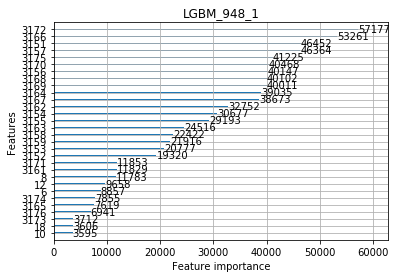

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.00886e-05	valid_0's local_loss: 1.78107
[100]	valid_0's l2: 1.64133e-06	valid_0's local_loss: 0.599014
[150]	valid_0's l2: 1.13182e-06	valid_0's local_loss: 0.48535
[200]	valid_0's l2: 9.90578e-07	valid_0's local_loss: 0.447273
[250]	valid_0's l2: 9.24097e-07	valid_0's local_loss: 0.426917
[300]	valid_0's l2: 8.83089e-07	valid_0's local_loss: 0.414131
[350]	valid_0's l2: 8.57694e-07	valid_0's local_loss: 0.405599
[400]	valid_0's l2: 8.40623e-07	valid_0's local_loss: 0.399783
[450]	valid_0's l2: 8.29481e-07	valid_0's local_loss: 0.395771
[500]	valid_0's l2: 8.22363e-07	valid_0's local_loss: 0.392627
[550]	valid_0's l2: 8.14754e-07	valid_0's local_loss: 0.389856
[600]	valid_0's l2: 8.09643e-07	valid_0's local_loss: 0.387972
[650]	valid_0's l2: 8.05213e-07	valid_0's local_loss: 0.386388
[700]	valid_0's l2: 8.01783e-07	valid_0's local_loss: 0.384865
[750]	valid_0's l2: 7.98631e-07	val

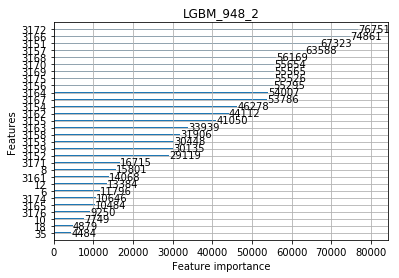

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.96697e-06	valid_0's local_loss: 1.75998
[100]	valid_0's l2: 1.7806e-06	valid_0's local_loss: 0.598962
[150]	valid_0's l2: 1.2736e-06	valid_0's local_loss: 0.483697
[200]	valid_0's l2: 1.11717e-06	valid_0's local_loss: 0.445011
[250]	valid_0's l2: 1.04267e-06	valid_0's local_loss: 0.42411
[300]	valid_0's l2: 9.99e-07	valid_0's local_loss: 0.411056
[350]	valid_0's l2: 9.72743e-07	valid_0's local_loss: 0.402346
[400]	valid_0's l2: 9.54728e-07	valid_0's local_loss: 0.396909
[450]	valid_0's l2: 9.41202e-07	valid_0's local_loss: 0.39237
[500]	valid_0's l2: 9.31149e-07	valid_0's local_loss: 0.388659
[550]	valid_0's l2: 9.23781e-07	valid_0's local_loss: 0.386013
[600]	valid_0's l2: 9.17046e-07	valid_0's local_loss: 0.383709
[650]	valid_0's l2: 9.11966e-07	valid_0's local_loss: 0.38188
[700]	valid_0's l2: 9.08088e-07	valid_0's local_loss: 0.380235
[750]	valid_0's l2: 9.03262e-07	valid_0's 

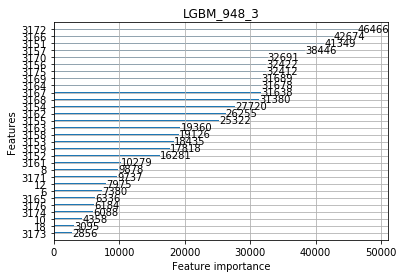

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.73573e-06	valid_0's local_loss: 1.74855
[100]	valid_0's l2: 1.47829e-06	valid_0's local_loss: 0.580325
[150]	valid_0's l2: 1.00727e-06	valid_0's local_loss: 0.468069
[200]	valid_0's l2: 8.81613e-07	valid_0's local_loss: 0.431696
[250]	valid_0's l2: 8.26477e-07	valid_0's local_loss: 0.412673
[300]	valid_0's l2: 7.91876e-07	valid_0's local_loss: 0.400401
[350]	valid_0's l2: 7.74623e-07	valid_0's local_loss: 0.393257
[400]	valid_0's l2: 7.61392e-07	valid_0's local_loss: 0.387868
[450]	valid_0's l2: 7.51583e-07	valid_0's local_loss: 0.384228
[500]	valid_0's l2: 7.43608e-07	valid_0's local_loss: 0.380599
[550]	valid_0's l2: 7.37174e-07	valid_0's local_loss: 0.377988
[600]	valid_0's l2: 7.32712e-07	valid_0's local_loss: 0.375816
[650]	valid_0's l2: 7.28732e-07	valid_0's local_loss: 0.374023
[700]	valid_0's l2: 7.24275e-07	valid_0's local_loss: 0.372372
[750]	valid_0's l2: 7.21586e-07	va

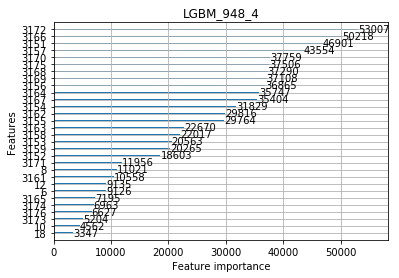

local_loss__= 0.36704645456778257
idx: 2, seed:83, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.05534e-05	valid_0's local_loss: 1.79162
[100]	valid_0's l2: 1.8858e-06	valid_0's local_loss: 0.614086
[150]	valid_0's l2: 1.33316e-06	valid_0's local_loss: 0.495539
[200]	valid_0's l2: 1.15847e-06	valid_0's local_loss: 0.455458
[250]	valid_0's l2: 1.077e-06	valid_0's local_loss: 0.435084
[300]	valid_0's l2: 1.03209e-06	valid_0's local_loss: 0.422075
[350]	valid_0's l2: 1.00112e-06	valid_0's local_loss: 0.413449
[400]	valid_0's l2: 9.78511e-07	valid_0's local_loss: 0.407174
[450]	valid_0's l2: 9.61627e-07	valid_0's local_loss: 0.402272
[500]	valid_0's l2: 9.49397e-07	valid_0's local_loss: 0.398689
[550]	valid_0's l2: 9.40214e-07	valid_0's local_loss: 0.395849
[600]	valid_0's l2: 9.3395e-07	valid_0's local_loss: 0.393585
[650]	valid_0's l2: 9.26674e-07	valid_0's local_loss: 0.391587
[700]	valid_0's l2: 9.21641e-07	valid_0'

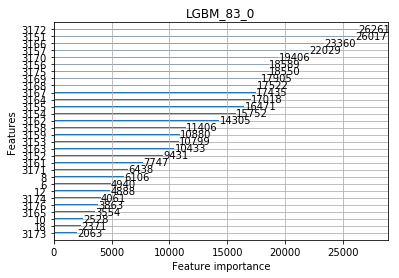

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.44916e-06	valid_0's local_loss: 1.73002
[100]	valid_0's l2: 1.5512e-06	valid_0's local_loss: 0.575193
[150]	valid_0's l2: 1.12989e-06	valid_0's local_loss: 0.469516
[200]	valid_0's l2: 1.00292e-06	valid_0's local_loss: 0.431582
[250]	valid_0's l2: 9.39739e-07	valid_0's local_loss: 0.411391
[300]	valid_0's l2: 9.07756e-07	valid_0's local_loss: 0.399396
[350]	valid_0's l2: 8.87774e-07	valid_0's local_loss: 0.391232
[400]	valid_0's l2: 8.74931e-07	valid_0's local_loss: 0.386352
[450]	valid_0's l2: 8.65288e-07	valid_0's local_loss: 0.382028
[500]	valid_0's l2: 8.58084e-07	valid_0's local_loss: 0.378755
[550]	valid_0's l2: 8.52829e-07	valid_0's local_loss: 0.376364
[600]	valid_0's l2: 8.4788e-07	valid_0's local_loss: 0.374051
[650]	valid_0's l2: 8.42949e-07	valid_0's local_loss: 0.372219
[700]	valid_0's l2: 8.39829e-07	valid_0's local_loss: 0.37074
[750]	valid_0's l2: 8.36385e-07	valid

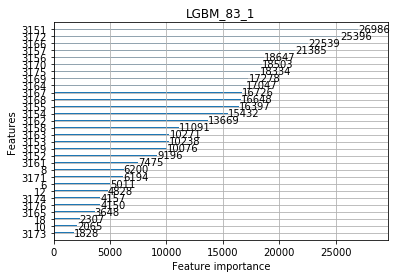

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.00262e-05	valid_0's local_loss: 1.77502
[100]	valid_0's l2: 1.6378e-06	valid_0's local_loss: 0.59436
[150]	valid_0's l2: 1.14012e-06	valid_0's local_loss: 0.481675
[200]	valid_0's l2: 1.00116e-06	valid_0's local_loss: 0.443802
[250]	valid_0's l2: 9.35533e-07	valid_0's local_loss: 0.424518
[300]	valid_0's l2: 8.96373e-07	valid_0's local_loss: 0.411856
[350]	valid_0's l2: 8.71141e-07	valid_0's local_loss: 0.403677
[400]	valid_0's l2: 8.55113e-07	valid_0's local_loss: 0.398465
[450]	valid_0's l2: 8.44221e-07	valid_0's local_loss: 0.394603
[500]	valid_0's l2: 8.34299e-07	valid_0's local_loss: 0.391618
[550]	valid_0's l2: 8.27464e-07	valid_0's local_loss: 0.389143
[600]	valid_0's l2: 8.22249e-07	valid_0's local_loss: 0.38716
[650]	valid_0's l2: 8.18002e-07	valid_0's local_loss: 0.38568
[700]	valid_0's l2: 8.14262e-07	valid_0's local_loss: 0.384274
[750]	valid_0's l2: 8.11167e-07	valid_

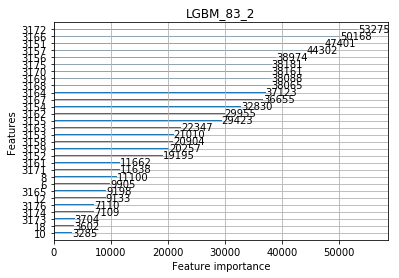

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 1.03095e-05	valid_0's local_loss: 1.78689
[100]	valid_0's l2: 1.85168e-06	valid_0's local_loss: 0.607927
[150]	valid_0's l2: 1.36079e-06	valid_0's local_loss: 0.493344
[200]	valid_0's l2: 1.20902e-06	valid_0's local_loss: 0.453417
[250]	valid_0's l2: 1.14152e-06	valid_0's local_loss: 0.433245
[300]	valid_0's l2: 1.10346e-06	valid_0's local_loss: 0.421192
[350]	valid_0's l2: 1.0803e-06	valid_0's local_loss: 0.413189
[400]	valid_0's l2: 1.06364e-06	valid_0's local_loss: 0.407601
[450]	valid_0's l2: 1.05205e-06	valid_0's local_loss: 0.403247
[500]	valid_0's l2: 1.04326e-06	valid_0's local_loss: 0.399934
[550]	valid_0's l2: 1.03572e-06	valid_0's local_loss: 0.39715
[600]	valid_0's l2: 1.03011e-06	valid_0's local_loss: 0.394876
[650]	valid_0's l2: 1.02476e-06	valid_0's local_loss: 0.393129
[700]	valid_0's l2: 1.02188e-06	valid_0's local_loss: 0.391695
[750]	valid_0's l2: 1.01881e-06	vali

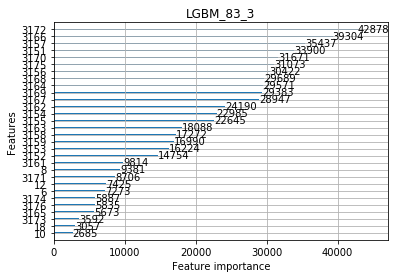

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 9.8001e-06	valid_0's local_loss: 1.76623
[100]	valid_0's l2: 1.45373e-06	valid_0's local_loss: 0.582948
[150]	valid_0's l2: 1.0035e-06	valid_0's local_loss: 0.471705
[200]	valid_0's l2: 8.85153e-07	valid_0's local_loss: 0.434465
[250]	valid_0's l2: 8.36357e-07	valid_0's local_loss: 0.41594
[300]	valid_0's l2: 8.07433e-07	valid_0's local_loss: 0.404244
[350]	valid_0's l2: 7.88139e-07	valid_0's local_loss: 0.396765
[400]	valid_0's l2: 7.74122e-07	valid_0's local_loss: 0.391035
[450]	valid_0's l2: 7.63303e-07	valid_0's local_loss: 0.386902
[500]	valid_0's l2: 7.55698e-07	valid_0's local_loss: 0.383887
[550]	valid_0's l2: 7.48929e-07	valid_0's local_loss: 0.381376
[600]	valid_0's l2: 7.44325e-07	valid_0's local_loss: 0.379463
[650]	valid_0's l2: 7.40453e-07	valid_0's local_loss: 0.377802
[700]	valid_0's l2: 7.36476e-07	valid_0's local_loss: 0.376157
[750]	valid_0's l2: 7.32721e-07	valid

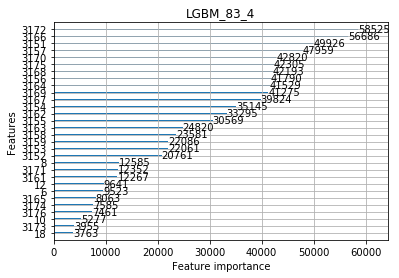

local_loss__= 0.36998454795979013
local_loss__= 0.33560043513088966


In [14]:
losses=train_single_LGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\Models/Model_p4',
                 seed_num=3, n_splits=5,lr=0.05)

In [15]:
import gc
del trainX,trainy
gc.collect()

6265

In [16]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p5')

trainX shape: (79267, 3126)
idx: 0, seed:228, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 13.1904	valid_0's local_loss: 0.62426
[100]	valid_0's l2: 2.22221	valid_0's local_loss: 0.0810721
[150]	valid_0's l2: 1.63152	valid_0's local_loss: 0.0463415
[200]	valid_0's l2: 1.47752	valid_0's local_loss: 0.0439592
[250]	valid_0's l2: 1.42471	valid_0's local_loss: 0.0436872
[300]	valid_0's l2: 1.39347	valid_0's local_loss: 0.043542
[350]	valid_0's l2: 1.36171	valid_0's local_loss: 0.0433317
[400]	valid_0's l2: 1.33927	valid_0's local_loss: 0.0432054
[450]	valid_0's l2: 1.31567	valid_0's local_loss: 0.0430637
[500]	valid_0's l2: 1.30258	valid_0's local_loss: 0.0429281
[550]	valid_0's l2: 1.29156	valid_0's local_loss: 0.0428747
[600]	valid_0's l2: 1.27993	valid_0's local_loss: 0.0428779
[650]	valid_0's l2: 1.27237	valid_0's local_loss: 0.0428336
[700]	valid_0's l2: 1.26732	valid_0's local_loss: 0.0428339
[750]	valid_0's l2: 1.

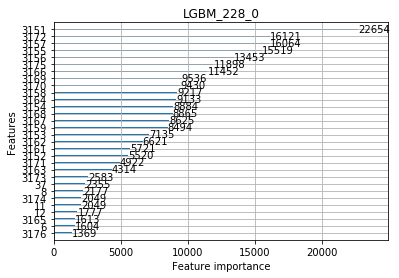

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.0542	valid_0's local_loss: 0.615634
[100]	valid_0's l2: 1.78111	valid_0's local_loss: 0.0803787
[150]	valid_0's l2: 1.42456	valid_0's local_loss: 0.0478967
[200]	valid_0's l2: 1.3082	valid_0's local_loss: 0.0463107
[250]	valid_0's l2: 1.25048	valid_0's local_loss: 0.0461333
Early stopping, best iteration is:
[223]	valid_0's l2: 1.27169	valid_0's local_loss: 0.0460334
model is fitted, take time 47.7665, model is saved to LGBM_228_1_20200326_184032
画特征重要性排序...


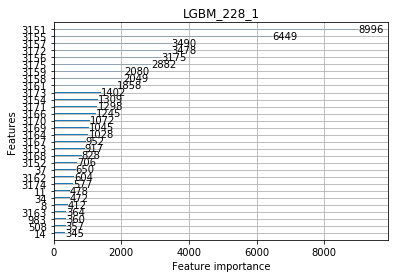

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 10.8356	valid_0's local_loss: 0.611666
[100]	valid_0's l2: 0.851257	valid_0's local_loss: 0.068837
[150]	valid_0's l2: 0.561129	valid_0's local_loss: 0.0361065
[200]	valid_0's l2: 0.522359	valid_0's local_loss: 0.0347768
[250]	valid_0's l2: 0.521235	valid_0's local_loss: 0.035117
Early stopping, best iteration is:
[200]	valid_0's l2: 0.522359	valid_0's local_loss: 0.0347768
model is fitted, take time 44.7848, model is saved to LGBM_228_2_20200326_184120
画特征重要性排序...


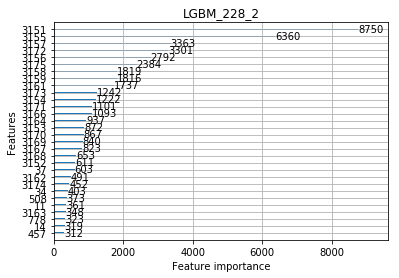

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.7504	valid_0's local_loss: 0.62189
[100]	valid_0's l2: 1.87897	valid_0's local_loss: 0.0789568
[150]	valid_0's l2: 1.26803	valid_0's local_loss: 0.0445301
[200]	valid_0's l2: 1.11598	valid_0's local_loss: 0.04254
[250]	valid_0's l2: 1.04631	valid_0's local_loss: 0.042125
[300]	valid_0's l2: 1.00024	valid_0's local_loss: 0.041804
[350]	valid_0's l2: 0.973529	valid_0's local_loss: 0.0416805
[400]	valid_0's l2: 0.96	valid_0's local_loss: 0.0416471
[450]	valid_0's l2: 0.948091	valid_0's local_loss: 0.0416303
Early stopping, best iteration is:
[436]	valid_0's l2: 0.947833	valid_0's local_loss: 0.0415635
model is fitted, take time 80.2077, model is saved to LGBM_228_3_20200326_184243
画特征重要性排序...


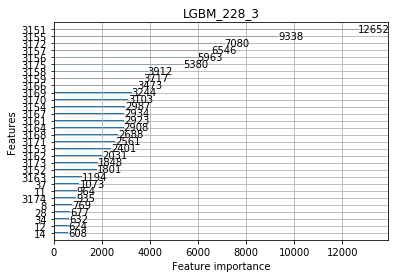

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.6826	valid_0's local_loss: 0.612924
[100]	valid_0's l2: 2.71039	valid_0's local_loss: 0.0763508
[150]	valid_0's l2: 2.33198	valid_0's local_loss: 0.0420076
[200]	valid_0's l2: 2.20653	valid_0's local_loss: 0.0402131
[250]	valid_0's l2: 2.14577	valid_0's local_loss: 0.0399116
[300]	valid_0's l2: 2.09105	valid_0's local_loss: 0.039863
[350]	valid_0's l2: 2.05321	valid_0's local_loss: 0.0398831
Early stopping, best iteration is:
[329]	valid_0's l2: 2.06395	valid_0's local_loss: 0.0397588
model is fitted, take time 62.4304, model is saved to LGBM_228_4_20200326_184349
画特征重要性排序...


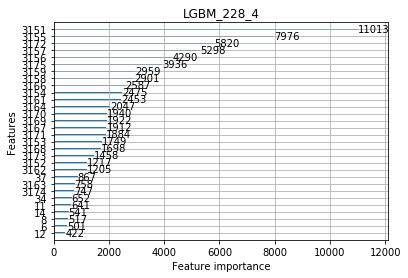

local_loss__= 0.04092300462824246
idx: 1, seed:164, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 10.6642	valid_0's local_loss: 0.613642
[100]	valid_0's l2: 0.750526	valid_0's local_loss: 0.0695612
[150]	valid_0's l2: 0.54702	valid_0's local_loss: 0.0357555
[200]	valid_0's l2: 0.526552	valid_0's local_loss: 0.0344074
[250]	valid_0's l2: 0.532091	valid_0's local_loss: 0.0345881
Early stopping, best iteration is:
[218]	valid_0's l2: 0.52286	valid_0's local_loss: 0.0343521
model is fitted, take time 47.3712, model is saved to LGBM_164_0_20200326_184440
画特征重要性排序...


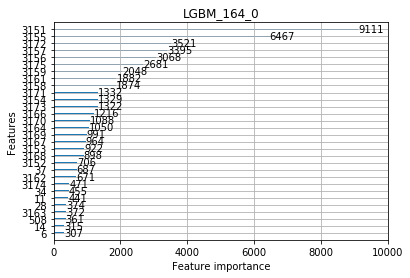

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 14.5049	valid_0's local_loss: 0.626073
[100]	valid_0's l2: 3.55636	valid_0's local_loss: 0.0853931
[150]	valid_0's l2: 2.93108	valid_0's local_loss: 0.0507713
[200]	valid_0's l2: 2.75363	valid_0's local_loss: 0.0489468
[250]	valid_0's l2: 2.66384	valid_0's local_loss: 0.0487431
[300]	valid_0's l2: 2.60155	valid_0's local_loss: 0.048811
Early stopping, best iteration is:
[263]	valid_0's l2: 2.64428	valid_0's local_loss: 0.0486836
model is fitted, take time 54.4087, model is saved to LGBM_164_1_20200326_184537
画特征重要性排序...


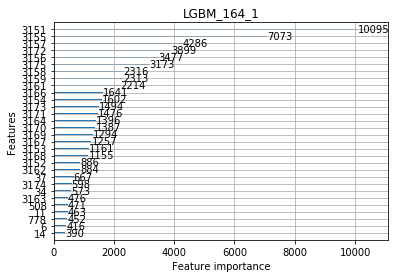

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.9374	valid_0's local_loss: 0.619308
[100]	valid_0's l2: 1.23018	valid_0's local_loss: 0.0763943
[150]	valid_0's l2: 0.866422	valid_0's local_loss: 0.0425451
[200]	valid_0's l2: 0.781424	valid_0's local_loss: 0.0405219
[250]	valid_0's l2: 0.741116	valid_0's local_loss: 0.0401334
[300]	valid_0's l2: 0.714907	valid_0's local_loss: 0.0399188
[350]	valid_0's l2: 0.695963	valid_0's local_loss: 0.0398154
[400]	valid_0's l2: 0.680406	valid_0's local_loss: 0.039708
[450]	valid_0's l2: 0.668835	valid_0's local_loss: 0.039607
Early stopping, best iteration is:
[440]	valid_0's l2: 0.66843	valid_0's local_loss: 0.0395839
model is fitted, take time 82.4525, model is saved to LGBM_164_2_20200326_184703
画特征重要性排序...


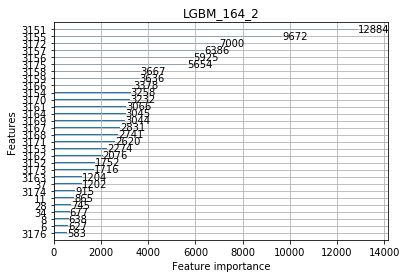

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.7464	valid_0's local_loss: 0.614988
[100]	valid_0's l2: 2.54392	valid_0's local_loss: 0.0781159
[150]	valid_0's l2: 2.06123	valid_0's local_loss: 0.0434521
[200]	valid_0's l2: 1.96159	valid_0's local_loss: 0.0413745
[250]	valid_0's l2: 1.91361	valid_0's local_loss: 0.041031
[300]	valid_0's l2: 1.87896	valid_0's local_loss: 0.040941
[350]	valid_0's l2: 1.85277	valid_0's local_loss: 0.0409023
[400]	valid_0's l2: 1.83187	valid_0's local_loss: 0.04084
[450]	valid_0's l2: 1.81863	valid_0's local_loss: 0.0407619
[500]	valid_0's l2: 1.8061	valid_0's local_loss: 0.0407472
[550]	valid_0's l2: 1.7931	valid_0's local_loss: 0.0406343
Early stopping, best iteration is:
[526]	valid_0's l2: 1.79077	valid_0's local_loss: 0.0405947
model is fitted, take time 92.3280, model is saved to LGBM_164_3_20200326_184838
画特征重要性排序...


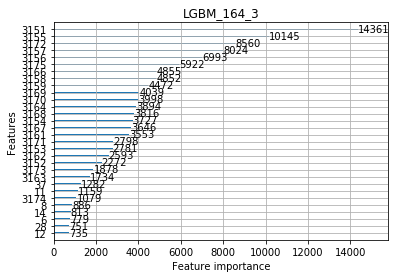

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.7057	valid_0's local_loss: 0.61195
[100]	valid_0's l2: 1.45503	valid_0's local_loss: 0.0729657
[150]	valid_0's l2: 1.02793	valid_0's local_loss: 0.039072
[200]	valid_0's l2: 0.935779	valid_0's local_loss: 0.0376246
[250]	valid_0's l2: 0.898976	valid_0's local_loss: 0.0377059
Early stopping, best iteration is:
[226]	valid_0's l2: 0.910316	valid_0's local_loss: 0.0375509
model is fitted, take time 49.2218, model is saved to LGBM_164_4_20200326_184932
画特征重要性排序...


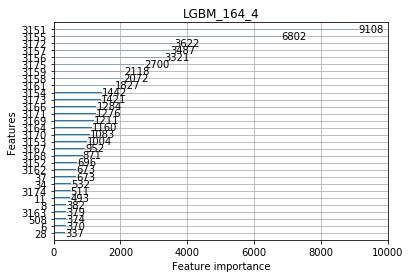

local_loss__= 0.04015307401925363
idx: 2, seed:737, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 14.8266	valid_0's local_loss: 0.640368
[100]	valid_0's l2: 3.20847	valid_0's local_loss: 0.0929195
[150]	valid_0's l2: 2.45829	valid_0's local_loss: 0.0577277
[200]	valid_0's l2: 2.19866	valid_0's local_loss: 0.054738
[250]	valid_0's l2: 2.0868	valid_0's local_loss: 0.0538706
[300]	valid_0's l2: 2.01228	valid_0's local_loss: 0.053572
[350]	valid_0's l2: 1.96304	valid_0's local_loss: 0.0534186
[400]	valid_0's l2: 1.90749	valid_0's local_loss: 0.0532349
[450]	valid_0's l2: 1.86243	valid_0's local_loss: 0.0530743
[500]	valid_0's l2: 1.82029	valid_0's local_loss: 0.0528875
[550]	valid_0's l2: 1.78375	valid_0's local_loss: 0.0527347
[600]	valid_0's l2: 1.75158	valid_0's local_loss: 0.0526484
[650]	valid_0's l2: 1.72394	valid_0's local_loss: 0.0525163
[700]	valid_0's l2: 1.70767	valid_0's local_loss: 0.0524943
[750]	valid_0's l

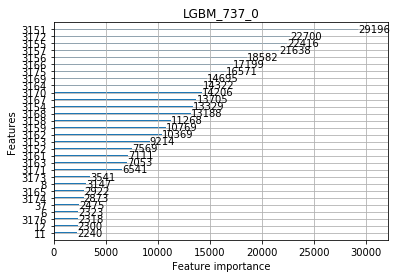

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.7459	valid_0's local_loss: 0.60882
[100]	valid_0's l2: 1.78739	valid_0's local_loss: 0.0730129
[150]	valid_0's l2: 1.57425	valid_0's local_loss: 0.039166
[200]	valid_0's l2: 1.51006	valid_0's local_loss: 0.0375626
[250]	valid_0's l2: 1.472	valid_0's local_loss: 0.0371816
[300]	valid_0's l2: 1.43629	valid_0's local_loss: 0.0368229
[350]	valid_0's l2: 1.4138	valid_0's local_loss: 0.0366079
[400]	valid_0's l2: 1.4006	valid_0's local_loss: 0.0365297
Early stopping, best iteration is:
[386]	valid_0's l2: 1.40399	valid_0's local_loss: 0.0364787
model is fitted, take time 73.1332, model is saved to LGBM_737_1_20200326_185451
画特征重要性排序...


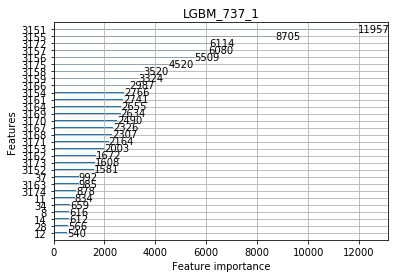

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.5414	valid_0's local_loss: 0.61278
[100]	valid_0's l2: 1.29093	valid_0's local_loss: 0.0713369
[150]	valid_0's l2: 0.774153	valid_0's local_loss: 0.0368199
[200]	valid_0's l2: 0.646907	valid_0's local_loss: 0.0350912
[250]	valid_0's l2: 0.600666	valid_0's local_loss: 0.0347666
[300]	valid_0's l2: 0.570034	valid_0's local_loss: 0.034596
[350]	valid_0's l2: 0.538671	valid_0's local_loss: 0.0342895
[400]	valid_0's l2: 0.516715	valid_0's local_loss: 0.0340614
[450]	valid_0's l2: 0.50299	valid_0's local_loss: 0.0339394
[500]	valid_0's l2: 0.493529	valid_0's local_loss: 0.0338788
[550]	valid_0's l2: 0.487027	valid_0's local_loss: 0.0338842
Early stopping, best iteration is:
[504]	valid_0's l2: 0.492963	valid_0's local_loss: 0.0338546
model is fitted, take time 92.3046, model is saved to LGBM_737_2_20200326_185627
画特征重要性排序...


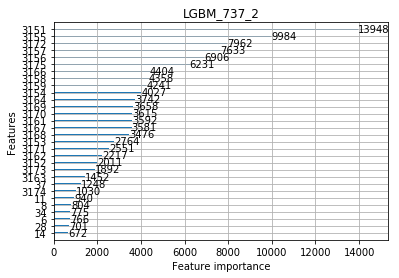

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.3207	valid_0's local_loss: 0.609297
[100]	valid_0's l2: 2.11257	valid_0's local_loss: 0.0764061
[150]	valid_0's l2: 1.51018	valid_0's local_loss: 0.0425856
[200]	valid_0's l2: 1.4121	valid_0's local_loss: 0.0414066
[250]	valid_0's l2: 1.36454	valid_0's local_loss: 0.0411694
[300]	valid_0's l2: 1.32719	valid_0's local_loss: 0.0411246
[350]	valid_0's l2: 1.30888	valid_0's local_loss: 0.0411492
Early stopping, best iteration is:
[304]	valid_0's l2: 1.32695	valid_0's local_loss: 0.0410972
model is fitted, take time 61.9446, model is saved to LGBM_737_3_20200326_185733
画特征重要性排序...


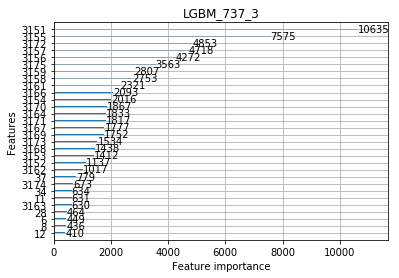

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.0733	valid_0's local_loss: 0.61622
[100]	valid_0's l2: 1.15221	valid_0's local_loss: 0.0727192
[150]	valid_0's l2: 0.970679	valid_0's local_loss: 0.039436
[200]	valid_0's l2: 0.916964	valid_0's local_loss: 0.0381506
[250]	valid_0's l2: 0.905291	valid_0's local_loss: 0.0381696
Early stopping, best iteration is:
[208]	valid_0's l2: 0.914466	valid_0's local_loss: 0.0380857
model is fitted, take time 45.3309, model is saved to LGBM_737_4_20200326_185821
画特征重要性排序...


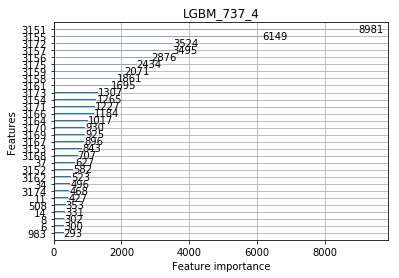

local_loss__= 0.0401256428131064
local_loss__= 0.035545366988096745


In [17]:
losses=train_single_LGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\Models/Model_p5',
                 seed_num=3, n_splits=5,lr=0.05)

In [18]:
import gc
del trainX,trainy
gc.collect()

18652

In [19]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p6')

trainX shape: (79267, 3126)
idx: 0, seed:536, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 10.899	valid_0's local_loss: 0.607437
[100]	valid_0's l2: 1.13471	valid_0's local_loss: 0.0726658
[150]	valid_0's l2: 0.858869	valid_0's local_loss: 0.0389047
[200]	valid_0's l2: 0.767965	valid_0's local_loss: 0.0373604
[250]	valid_0's l2: 0.728184	valid_0's local_loss: 0.0372675
Early stopping, best iteration is:
[232]	valid_0's l2: 0.740442	valid_0's local_loss: 0.0371828
model is fitted, take time 49.8508, model is saved to LGBM_536_0_20200326_191446
画特征重要性排序...


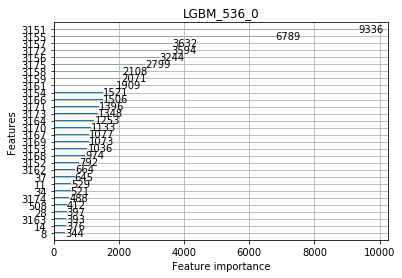

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.8337	valid_0's local_loss: 0.614113
[100]	valid_0's l2: 1.52789	valid_0's local_loss: 0.0707818
[150]	valid_0's l2: 0.899047	valid_0's local_loss: 0.0356028
[200]	valid_0's l2: 0.765546	valid_0's local_loss: 0.0334637
[250]	valid_0's l2: 0.716497	valid_0's local_loss: 0.0331225
[300]	valid_0's l2: 0.69211	valid_0's local_loss: 0.0329383
Early stopping, best iteration is:
[271]	valid_0's l2: 0.70196	valid_0's local_loss: 0.0329055
model is fitted, take time 54.9323, model is saved to LGBM_536_1_20200326_191544
画特征重要性排序...


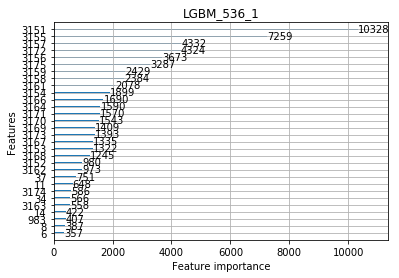

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.4591	valid_0's local_loss: 0.617701
[100]	valid_0's l2: 1.12295	valid_0's local_loss: 0.0760895
[150]	valid_0's l2: 0.862849	valid_0's local_loss: 0.0419508
[200]	valid_0's l2: 0.823937	valid_0's local_loss: 0.0400334
[250]	valid_0's l2: 0.80202	valid_0's local_loss: 0.039705
[300]	valid_0's l2: 0.786979	valid_0's local_loss: 0.0396234
[350]	valid_0's l2: 0.777103	valid_0's local_loss: 0.0395355
[400]	valid_0's l2: 0.769791	valid_0's local_loss: 0.0394582
[450]	valid_0's l2: 0.763178	valid_0's local_loss: 0.039417
Early stopping, best iteration is:
[425]	valid_0's l2: 0.762756	valid_0's local_loss: 0.0394047
model is fitted, take time 79.0844, model is saved to LGBM_536_2_20200326_191707
画特征重要性排序...


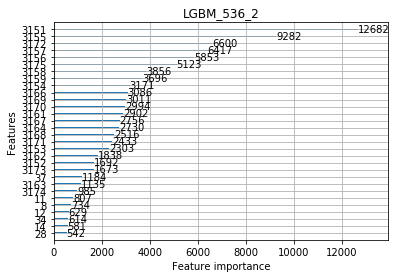

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 15.7568	valid_0's local_loss: 0.632574
[100]	valid_0's l2: 4.00402	valid_0's local_loss: 0.0851828
[150]	valid_0's l2: 3.10719	valid_0's local_loss: 0.0495819
[200]	valid_0's l2: 2.88077	valid_0's local_loss: 0.0476924
[250]	valid_0's l2: 2.73634	valid_0's local_loss: 0.0470005
[300]	valid_0's l2: 2.635	valid_0's local_loss: 0.0466003
[350]	valid_0's l2: 2.56906	valid_0's local_loss: 0.0463231
[400]	valid_0's l2: 2.51021	valid_0's local_loss: 0.0460816
[450]	valid_0's l2: 2.46441	valid_0's local_loss: 0.0458434
[500]	valid_0's l2: 2.42962	valid_0's local_loss: 0.0456526
[550]	valid_0's l2: 2.40241	valid_0's local_loss: 0.0454745
[600]	valid_0's l2: 2.38111	valid_0's local_loss: 0.0454318
[650]	valid_0's l2: 2.36532	valid_0's local_loss: 0.0453979
[700]	valid_0's l2: 2.35435	valid_0's local_loss: 0.0453763
Early stopping, best iteration is:
[687]	valid_0's l2: 2.35564	valid_0's local

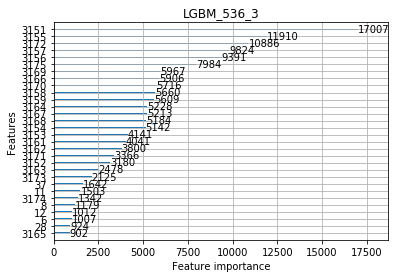

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.4075	valid_0's local_loss: 0.616996
[100]	valid_0's l2: 1.23838	valid_0's local_loss: 0.0768936
[150]	valid_0's l2: 0.933122	valid_0's local_loss: 0.0429777
[200]	valid_0's l2: 0.842743	valid_0's local_loss: 0.0411775
[250]	valid_0's l2: 0.796037	valid_0's local_loss: 0.040606
[300]	valid_0's l2: 0.77301	valid_0's local_loss: 0.0404286
[350]	valid_0's l2: 0.749867	valid_0's local_loss: 0.040175
[400]	valid_0's l2: 0.737313	valid_0's local_loss: 0.0399961
[450]	valid_0's l2: 0.728491	valid_0's local_loss: 0.0398956
[500]	valid_0's l2: 0.722375	valid_0's local_loss: 0.0397227
[550]	valid_0's l2: 0.719421	valid_0's local_loss: 0.0396267
[600]	valid_0's l2: 0.715617	valid_0's local_loss: 0.0395436
Early stopping, best iteration is:
[587]	valid_0's l2: 0.715129	valid_0's local_loss: 0.0395341
model is fitted, take time 102.5436, model is saved to LGBM_536_4_20200326_192050
画特征重要性排序...

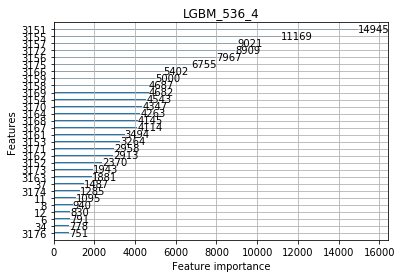

local_loss__= 0.03887518614320736
idx: 1, seed:901, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.586	valid_0's local_loss: 0.617212
[100]	valid_0's l2: 1.9348	valid_0's local_loss: 0.0743083
[150]	valid_0's l2: 1.41869	valid_0's local_loss: 0.039537
[200]	valid_0's l2: 1.2654	valid_0's local_loss: 0.0375457
[250]	valid_0's l2: 1.1917	valid_0's local_loss: 0.0371954
[300]	valid_0's l2: 1.14909	valid_0's local_loss: 0.0369818
[350]	valid_0's l2: 1.12521	valid_0's local_loss: 0.0370227
Early stopping, best iteration is:
[331]	valid_0's l2: 1.12745	valid_0's local_loss: 0.0369066
model is fitted, take time 63.9232, model is saved to LGBM_901_0_20200326_192158
画特征重要性排序...


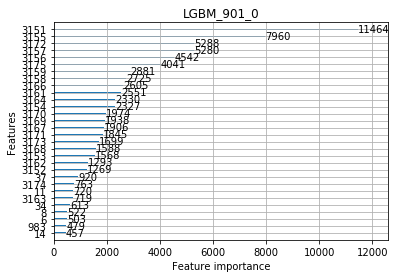

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.0905	valid_0's local_loss: 0.60976
[100]	valid_0's l2: 1.20082	valid_0's local_loss: 0.0737917
[150]	valid_0's l2: 0.91151	valid_0's local_loss: 0.0410535
[200]	valid_0's l2: 0.864455	valid_0's local_loss: 0.0394992
[250]	valid_0's l2: 0.846023	valid_0's local_loss: 0.0392872
[300]	valid_0's l2: 0.843234	valid_0's local_loss: 0.0393346
[350]	valid_0's l2: 0.827651	valid_0's local_loss: 0.0391467
[400]	valid_0's l2: 0.81774	valid_0's local_loss: 0.0390031
[450]	valid_0's l2: 0.805194	valid_0's local_loss: 0.0390229
Early stopping, best iteration is:
[433]	valid_0's l2: 0.807805	valid_0's local_loss: 0.0389536
model is fitted, take time 80.0775, model is saved to LGBM_901_1_20200326_192321
画特征重要性排序...


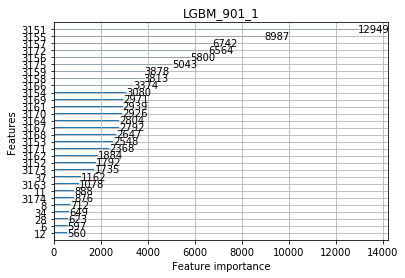

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.094	valid_0's local_loss: 0.611362
[100]	valid_0's l2: 1.96584	valid_0's local_loss: 0.07849
[150]	valid_0's l2: 1.56864	valid_0's local_loss: 0.0444841
[200]	valid_0's l2: 1.48937	valid_0's local_loss: 0.0428019
[250]	valid_0's l2: 1.4494	valid_0's local_loss: 0.0428851
Early stopping, best iteration is:
[205]	valid_0's l2: 1.4837	valid_0's local_loss: 0.0427228
model is fitted, take time 45.1417, model is saved to LGBM_901_2_20200326_192410
画特征重要性排序...


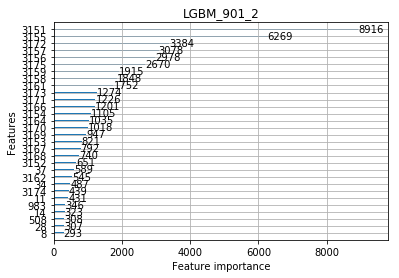

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.7486	valid_0's local_loss: 0.625698
[100]	valid_0's l2: 1.32566	valid_0's local_loss: 0.0789391
[150]	valid_0's l2: 0.98923	valid_0's local_loss: 0.0446843
[200]	valid_0's l2: 0.942234	valid_0's local_loss: 0.0429536
Early stopping, best iteration is:
[199]	valid_0's l2: 0.941775	valid_0's local_loss: 0.0429565
model is fitted, take time 44.6217, model is saved to LGBM_901_3_20200326_192457
画特征重要性排序...


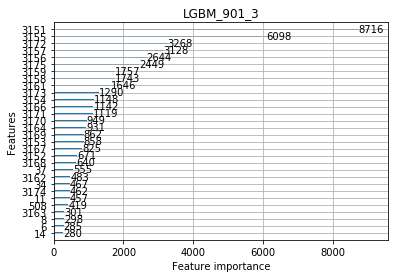

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 13.9548	valid_0's local_loss: 0.621329
[100]	valid_0's l2: 3.01625	valid_0's local_loss: 0.0816477
[150]	valid_0's l2: 2.56226	valid_0's local_loss: 0.0481485
[200]	valid_0's l2: 2.43569	valid_0's local_loss: 0.0464667
[250]	valid_0's l2: 2.3592	valid_0's local_loss: 0.0464869
Early stopping, best iteration is:
[215]	valid_0's l2: 2.41577	valid_0's local_loss: 0.0464002
model is fitted, take time 46.3420, model is saved to LGBM_901_4_20200326_192547
画特征重要性排序...


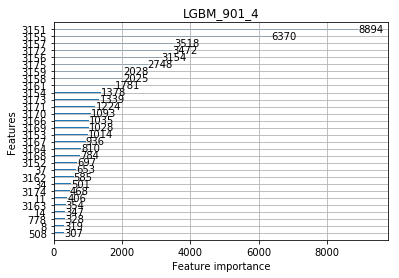

local_loss__= 0.0415878462943866
idx: 2, seed:337, num:3....
start to train on fold 1
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.4581	valid_0's local_loss: 0.611347
[100]	valid_0's l2: 2.23922	valid_0's local_loss: 0.0781363
[150]	valid_0's l2: 1.77649	valid_0's local_loss: 0.0436993
[200]	valid_0's l2: 1.67882	valid_0's local_loss: 0.0415823
[250]	valid_0's l2: 1.63336	valid_0's local_loss: 0.0411225
[300]	valid_0's l2: 1.60856	valid_0's local_loss: 0.0409149
[350]	valid_0's l2: 1.58934	valid_0's local_loss: 0.0407367
[400]	valid_0's l2: 1.57196	valid_0's local_loss: 0.0406001
[450]	valid_0's l2: 1.56586	valid_0's local_loss: 0.0406034
Early stopping, best iteration is:
[423]	valid_0's l2: 1.56794	valid_0's local_loss: 0.0405503
model is fitted, take time 78.4426, model is saved to LGBM_337_0_20200326_192709
画特征重要性排序...


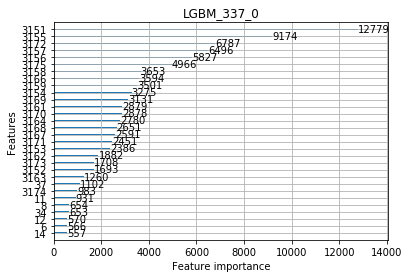

start to train on fold 2
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 12.4048	valid_0's local_loss: 0.62222
[100]	valid_0's l2: 2.07236	valid_0's local_loss: 0.0746917
[150]	valid_0's l2: 1.5601	valid_0's local_loss: 0.0399339
[200]	valid_0's l2: 1.37669	valid_0's local_loss: 0.0380873
[250]	valid_0's l2: 1.28496	valid_0's local_loss: 0.0376846
[300]	valid_0's l2: 1.21929	valid_0's local_loss: 0.037392
[350]	valid_0's l2: 1.18514	valid_0's local_loss: 0.0370925
[400]	valid_0's l2: 1.15949	valid_0's local_loss: 0.036897
[450]	valid_0's l2: 1.13005	valid_0's local_loss: 0.0366812
[500]	valid_0's l2: 1.11127	valid_0's local_loss: 0.0365432
[550]	valid_0's l2: 1.09512	valid_0's local_loss: 0.0364627
[600]	valid_0's l2: 1.0808	valid_0's local_loss: 0.0363932
Early stopping, best iteration is:
[598]	valid_0's l2: 1.08084	valid_0's local_loss: 0.0363917
model is fitted, take time 104.1188, model is saved to LGBM_337_1_20200326_192856
画特征重要性排序...


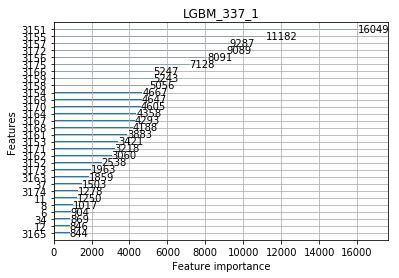

start to train on fold 3
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 11.9464	valid_0's local_loss: 0.618813
[100]	valid_0's l2: 1.15802	valid_0's local_loss: 0.0743549
[150]	valid_0's l2: 0.814618	valid_0's local_loss: 0.0408367
[200]	valid_0's l2: 0.752551	valid_0's local_loss: 0.0393525
[250]	valid_0's l2: 0.73742	valid_0's local_loss: 0.0393522
Early stopping, best iteration is:
[224]	valid_0's l2: 0.739279	valid_0's local_loss: 0.0392355
model is fitted, take time 47.7400, model is saved to LGBM_337_2_20200326_192948
画特征重要性排序...


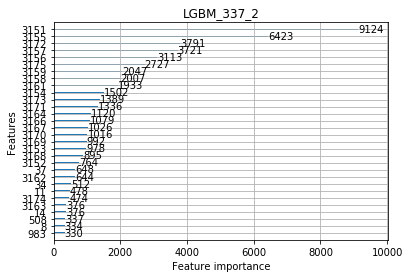

start to train on fold 4
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 10.3596	valid_0's local_loss: 0.607637
[100]	valid_0's l2: 0.730273	valid_0's local_loss: 0.0705469
[150]	valid_0's l2: 0.525857	valid_0's local_loss: 0.0366939
[200]	valid_0's l2: 0.487524	valid_0's local_loss: 0.0350191
[250]	valid_0's l2: 0.482148	valid_0's local_loss: 0.0351353
Early stopping, best iteration is:
[208]	valid_0's l2: 0.483438	valid_0's local_loss: 0.0349892
model is fitted, take time 45.7288, model is saved to LGBM_337_3_20200326_193036
画特征重要性排序...


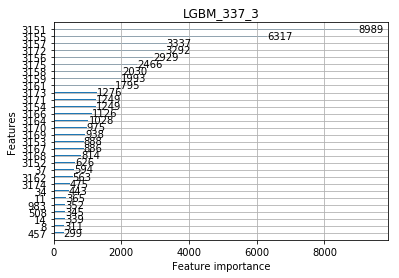

start to train on fold 5
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l2: 13.8537	valid_0's local_loss: 0.62664
[100]	valid_0's l2: 2.83733	valid_0's local_loss: 0.0846548
[150]	valid_0's l2: 2.17916	valid_0's local_loss: 0.0500022
[200]	valid_0's l2: 2.01872	valid_0's local_loss: 0.0483722
[250]	valid_0's l2: 1.94793	valid_0's local_loss: 0.048191
[300]	valid_0's l2: 1.8785	valid_0's local_loss: 0.0480293
[350]	valid_0's l2: 1.83907	valid_0's local_loss: 0.0478638
[400]	valid_0's l2: 1.79917	valid_0's local_loss: 0.047701
Early stopping, best iteration is:
[396]	valid_0's l2: 1.79967	valid_0's local_loss: 0.0476838
model is fitted, take time 74.0257, model is saved to LGBM_337_4_20200326_193153
画特征重要性排序...


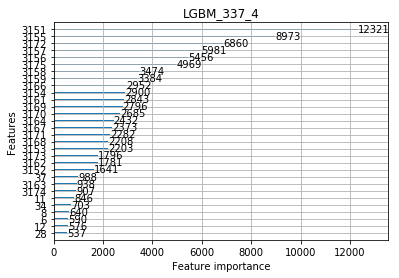

local_loss__= 0.03977006464015706
local_loss__= 0.03536392332550072


In [21]:
losses=train_single_LGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\Models/Model_p6',
                 seed_num=3, n_splits=5,lr=0.05)

#### 小结

至此，所有p1-p6的模型训练完成，下一步，考虑用平均法对subtest进行融合处理，求平均值

In [32]:
import joblib
def predict_subTest(sub_test_path,models_folder,result_save_path):
    os.makedirs(os.path.dirname(result_save_path),exist_ok=True)
    drop_cols = ['0', '1', '2', '3', '4', '5', '19', '21', '26', '32', '38', '39', '40', '41', '42', '43', '44', '45',
                 '46', '47', '48',
                 '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61',
                 '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78']
    use_cols = [str(i) for i in range(0, 3177) if str(i) not in drop_cols] + ['id']
    subtest_df=pd.read_csv(sub_test_path,usecols=use_cols)
    result_df=pd.DataFrame(subtest_df['id'])
    subtest_df.drop(['id'],axis=1,inplace=True)
    print('subtest_df.shape: ',subtest_df.shape)
    for i in range(1,7):
        model_folder='Model_p'+str(i)
        tmp_df=None
        print('start to predict: {}'.format(model_folder))
        for model_path in os.listdir(os.path.join(models_folder,model_folder)):
            model=joblib.load(os.path.join(models_folder,model_folder,model_path))
            pred=model.predict(subtest_df, num_iteration=model.best_iteration_)
            pred_df=pd.DataFrame(pred)
            tmp_df=pred_df if tmp_df is None else pd.concat([tmp_df,pred_df], axis=1)
            # print('tmp_df shape: ',tmp_df.shape)
        result_df['p'+str(i)]=tmp_df.mean(axis=1)
        # print('result_df.shape: ',result_df.shape)
    result_df.to_csv(result_save_path,index=False)
    print('DONE')

In [33]:
predict_subTest(r"E:\PyProjects\DataSet\Molecules\RawData\molecule_open_data\candidate_val.csv",
                r'E:\PyProjects\DataSet\Molecules\Baseline\Models',
                r'E:\PyProjects\DataSet\Molecules\Baseline\submit/submit_20200326_1.csv')

subtest_df.shape:  (26358, 3126)
start to predict: Model_p1
start to predict: Model_p2
start to predict: Model_p3
start to predict: Model_p4
start to predict: Model_p5
start to predict: Model_p6
DONE


#### 提交得分：8.1609

### 3. 使用XGBoost进行训练

In [41]:
import xgboost as xgb
def train_single_XGB(trainX,trainy, save_folder,seed_num=2, n_splits=5,lr=0.01):
    '''
    使用trainX,trainy, valX,valy来训练单个LGB回归器，使用K折样本融合的方式
    :param trainX:
    :param trainy:
    :param save_folder: 模型保存文件夹
    :param target_index:
    :param seed_num: 随机数的个数，每个随机数产生一个n_splits的交叉验证模型
    :param n_splits: 交叉验证的折数
    :return:
    '''

    def local_loss(y_pred, y_true):
        return 'local_loss', localLoss(y_true.get_label(), y_pred)

    os.makedirs(save_folder,exist_ok=True)
    pred_results=None
    print('trainX shape: {}'.format(trainX.shape))
    seedRandom = list(np.random.randint(0, 1000, 1000)) # 一千个随机数
    losses=[]
    for index, seed in enumerate(seedRandom[:seed_num]): # eg seed_num=3: enumerate([607,235,424])
        print("idx: {}, seed:{}, num:{}....".format(index,seed, seed_num))
        skf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        preds = np.zeros((trainX.shape[0],))
        for fold_, (trn_idx, val_idx) in enumerate(skf.split(trainX)):
            print("start to train on fold {}".format(fold_ + 1))
            trnX,trny = trainX.iloc[trn_idx], trainy.iloc[trn_idx]
            valX,valy = trainX.iloc[val_idx], trainy.iloc[val_idx]
            t0=time.time()
            model=xgb.XGBRegressor(n_estimators=10000,max_depth=127,learning_rate=lr,colsample_bytree=0.8,
                                   booster='gbtree',subsample=0.8,bagging_fraction=0.8)
            model.fit(trnX,trny,eval_set=[(valX,valy)],eval_metric=local_loss,early_stopping_rounds=10,verbose=True)
            save_name = 'XGB_' +str(seed)+'_' + str(fold_)+ '_'+datetime.now().strftime('%Y%m%d_%H%M%S')
            joblib.dump(model, os.path.join(save_folder, save_name))
            print('model is fitted, take time {:.4f}, model is saved to {}'.format(time.time()-t0, save_name))
            preds[val_idx] = model.predict(valX)

        if index==0:pred_results=pd.DataFrame(preds,columns=['round_0'])
        else: pred_results['round_'+str(index)]=preds
        # 查看这个round的local loss
        loss=localLoss(trainy,preds,True)
        losses.append(loss)
    ## 最终通过平均法对pred_results计算最终预测结果，得到最终losses:
    pred_results['mean']=pred_results.mean(axis=1)
    final_loss=localLoss(trainy,pred_results['mean'].values,True)
    losses.append(final_loss)
    return losses


In [42]:
import gc
del trainX,trainy
gc.collect()

612

In [43]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p1')

In [44]:
losses=train_single_XGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models/Model_p1',
                 seed_num=3, n_splits=5,lr=0.05)

trainX shape: (79267, 3126)
idx: 0, seed:227, num:3....
start to train on fold 1
[0]	validation_0-rmse:2.49417	validation_0-local_loss:114.94713
Multiple eval metrics have been passed: 'validation_0-local_loss' will be used for early stopping.

Will train until validation_0-local_loss hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.38630	validation_0-local_loss:106.07039
[2]	validation_0-rmse:2.28393	validation_0-local_loss:98.19086
[3]	validation_0-rmse:2.18729	validation_0-local_loss:91.19340
[4]	validation_0-rmse:2.09629	validation_0-local_loss:84.94598
[5]	validation_0-rmse:2.01023	validation_0-local_loss:79.31746
[6]	validation_0-rmse:1.92872	validation_0-local_loss:74.21232
[7]	validation_0-rmse:1.85140	validation_0-local_loss:69.62871
[8]	validation_0-rmse:1.77810	validation_0-local_loss:65.49080
[9]	validation_0-rmse:1.70878	validation_0-local_loss:61.70853
[10]	validation_0-rmse:1.64404	validation_0-local_loss:58.28136
[11]	validation_0-rmse:1.58276	validation_0-local_lo

In [45]:
import gc
del trainX,trainy
gc.collect()

11

In [46]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p2')
losses=train_single_XGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models/Model_p2',
                 seed_num=3, n_splits=5,lr=0.05)

trainX shape: (79267, 3126)
idx: 0, seed:718, num:3....
start to train on fold 1
[0]	validation_0-rmse:0.70337	validation_0-local_loss:200.00000
Multiple eval metrics have been passed: 'validation_0-local_loss' will be used for early stopping.

Will train until validation_0-local_loss hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.66821	validation_0-local_loss:200.00000
[2]	validation_0-rmse:0.63482	validation_0-local_loss:200.00000
[3]	validation_0-rmse:0.60310	validation_0-local_loss:200.00000
[4]	validation_0-rmse:0.57296	validation_0-local_loss:200.00000
[5]	validation_0-rmse:0.54434	validation_0-local_loss:200.00000
[6]	validation_0-rmse:0.51714	validation_0-local_loss:200.00000
[7]	validation_0-rmse:0.49131	validation_0-local_loss:200.00000
[8]	validation_0-rmse:0.46677	validation_0-local_loss:200.00000
[9]	validation_0-rmse:0.44346	validation_0-local_loss:200.00000
[10]	validation_0-rmse:0.42131	validation_0-local_loss:200.00000
Stopping. Best iteration:
[0]	validation_0-

In [47]:
import gc
del trainX,trainy
gc.collect()
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p3')
losses=train_single_XGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models/Model_p3',
                 seed_num=3, n_splits=5,lr=0.05)

trainX shape: (79267, 3126)
idx: 0, seed:594, num:3....
start to train on fold 1
[0]	validation_0-rmse:0.46532	validation_0-local_loss:180.46786
Multiple eval metrics have been passed: 'validation_0-local_loss' will be used for early stopping.

Will train until validation_0-local_loss hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.44211	validation_0-local_loss:179.66339
[2]	validation_0-rmse:0.42006	validation_0-local_loss:178.83057
[3]	validation_0-rmse:0.39913	validation_0-local_loss:177.97745
[4]	validation_0-rmse:0.37924	validation_0-local_loss:177.09628
[5]	validation_0-rmse:0.36034	validation_0-local_loss:176.19015
[6]	validation_0-rmse:0.34240	validation_0-local_loss:175.26200
[7]	validation_0-rmse:0.32535	validation_0-local_loss:174.30565
[8]	validation_0-rmse:0.30915	validation_0-local_loss:173.32909
[9]	validation_0-rmse:0.29376	validation_0-local_loss:172.32641
[10]	validation_0-rmse:0.27914	validation_0-local_loss:171.30327
[11]	validation_0-rmse:0.26525	validation_0

In [48]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p4')
losses=train_single_XGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models/Model_p4',
                 seed_num=3, n_splits=5,lr=0.05)

trainX shape: (79267, 3126)
idx: 0, seed:586, num:3....
start to train on fold 1
[0]	validation_0-rmse:0.33499	validation_0-local_loss:106.49396
Multiple eval metrics have been passed: 'validation_0-local_loss' will be used for early stopping.

Will train until validation_0-local_loss hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.31828	validation_0-local_loss:104.00025
[2]	validation_0-rmse:0.30241	validation_0-local_loss:101.50443
[3]	validation_0-rmse:0.28733	validation_0-local_loss:99.00637
[4]	validation_0-rmse:0.27299	validation_0-local_loss:96.51084
[5]	validation_0-rmse:0.25937	validation_0-local_loss:94.02044
[6]	validation_0-rmse:0.24643	validation_0-local_loss:91.53753
[7]	validation_0-rmse:0.23413	validation_0-local_loss:89.06538
[8]	validation_0-rmse:0.22245	validation_0-local_loss:86.60552
[9]	validation_0-rmse:0.21135	validation_0-local_loss:84.16417
[10]	validation_0-rmse:0.20082	validation_0-local_loss:81.74094
[11]	validation_0-rmse:0.19080	validation_0-local_l

In [49]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p5')
losses=train_single_XGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models/Model_p5',
                 seed_num=3, n_splits=5,lr=0.05)

trainX shape: (79267, 3126)
idx: 0, seed:626, num:3....
start to train on fold 1
[0]	validation_0-rmse:392.85318	validation_0-local_loss:181.37518
Multiple eval metrics have been passed: 'validation_0-local_loss' will be used for early stopping.

Will train until validation_0-local_loss hasn't improved in 10 rounds.
[1]	validation_0-rmse:373.21793	validation_0-local_loss:164.83265
[2]	validation_0-rmse:354.56403	validation_0-local_loss:150.39273
[3]	validation_0-rmse:336.84332	validation_0-local_loss:137.69590
[4]	validation_0-rmse:320.00836	validation_0-local_loss:126.45740
[5]	validation_0-rmse:304.01477	validation_0-local_loss:116.45215
[6]	validation_0-rmse:288.82214	validation_0-local_loss:107.50072
[7]	validation_0-rmse:274.39035	validation_0-local_loss:99.45477
[8]	validation_0-rmse:260.68680	validation_0-local_loss:92.18747
[9]	validation_0-rmse:247.66040	validation_0-local_loss:85.60625
[10]	validation_0-rmse:235.29355	validation_0-local_loss:79.62080
[11]	validation_0-rmse:22

In [50]:
trainX,trainy=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p6')
losses=train_single_XGB(trainX,trainy, r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models/Model_p6',
                 seed_num=3, n_splits=5,lr=0.05)

trainX shape: (79267, 3126)
idx: 0, seed:349, num:3....
start to train on fold 1
[0]	validation_0-rmse:392.47730	validation_0-local_loss:181.37679
Multiple eval metrics have been passed: 'validation_0-local_loss' will be used for early stopping.

Will train until validation_0-local_loss hasn't improved in 10 rounds.
[1]	validation_0-rmse:372.86157	validation_0-local_loss:164.83426
[2]	validation_0-rmse:354.22601	validation_0-local_loss:150.39478
[3]	validation_0-rmse:336.52145	validation_0-local_loss:137.69894
[4]	validation_0-rmse:319.70352	validation_0-local_loss:126.46130
[5]	validation_0-rmse:303.72675	validation_0-local_loss:116.45682
[6]	validation_0-rmse:288.54758	validation_0-local_loss:107.50401
[7]	validation_0-rmse:274.12817	validation_0-local_loss:99.45666
[8]	validation_0-rmse:260.44180	validation_0-local_loss:92.19121
[9]	validation_0-rmse:247.42810	validation_0-local_loss:85.60947
[10]	validation_0-rmse:235.07286	validation_0-local_loss:79.62326
[11]	validation_0-rmse:22

### 3. 使用XGBoost的模型来进行预测

In [5]:
import joblib
def predict_subTest(sub_test_path,models_folder,result_save_path,is_LGB=True):
    os.makedirs(os.path.dirname(result_save_path),exist_ok=True)
    drop_cols = ['0', '1', '2', '3', '4', '5', '19', '21', '26', '32', '38', '39', '40', '41', '42', '43', '44', '45',
                 '46', '47', '48',
                 '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61',
                 '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78']
    use_cols = [str(i) for i in range(0, 3177) if str(i) not in drop_cols] + ['id']
    subtest_df=pd.read_csv(sub_test_path,usecols=use_cols)
    result_df=pd.DataFrame(subtest_df['id'])
    subtest_df.drop(['id'],axis=1,inplace=True)
    print('subtest_df.shape: ',subtest_df.shape)
    for i in range(1,7):
        model_folder='Model_p'+str(i)
        tmp_df=None
        print('start to predict: {}'.format(model_folder))
        for model_path in os.listdir(os.path.join(models_folder,model_folder)):
            model=joblib.load(os.path.join(models_folder,model_folder,model_path))
            pred=model.predict(subtest_df, num_iteration=model.best_iteration_) if is_LGB else pred=model.predict(subtest_df)
            pred_df=pd.DataFrame(pred)
            tmp_df=pred_df if tmp_df is None else pd.concat([tmp_df,pred_df], axis=1)
            # print('tmp_df shape: ',tmp_df.shape)
        result_df['p'+str(i)]=tmp_df.mean(axis=1)
        # print('result_df.shape: ',result_df.shape)
    result_df.to_csv(result_save_path,index=False)
    print('DONE')

In [6]:
import os
import pandas as pd
predict_subTest(r"E:\PyProjects\DataSet\Molecules\RawData\molecule_open_data\candidate_val.csv",
                r'E:\PyProjects\DataSet\Molecules\Baseline\XGB_Models',
                r'E:\PyProjects\DataSet\Molecules\Baseline\submit/submit_20200330_1.csv')

subtest_df.shape:  (26358, 3126)
start to predict: Model_p1
start to predict: Model_p2
start to predict: Model_p3
start to predict: Model_p4
start to predict: Model_p5
start to predict: Model_p6
DONE


#### 提交结果：41.79，这个比LGBM要差得多。LGBM是8.16，分数越小越好

### 3. 用catboost训练

#### 3.1 确定哪些列可以作为类别列

In [7]:
def get_cols_nunique(train_path):
    drop_cols=['0','1','2','3','4','5','19','21','26','32','38','39','40','41','42','43','44','45','46','47','48',
               '49','50','51','52','53','54','55','56','57','58','59','60','61',
              '62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78']
    use_cols=[str(i) for i in range(0,3177) if str(i) not in drop_cols]+['id']
    train_df=pd.read_csv(train_path,usecols=use_cols)
    result={}
    for col in train_df.columns:
        result[col]=train_df[col].nunique()
    return sorted(result.items(), key=lambda d: d[1])

In [8]:
path=r'E:\PyProjects\DataSet\Molecules\RawData\molecule_open_data/'
result=get_cols_nunique(path+"candidate_train.csv")

(array([3.112e+03, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.400e+01]),
 array([2.00000e+00, 7.92850e+03, 1.58550e+04, 2.37815e+04, 3.17080e+04,
        3.96345e+04, 4.75610e+04, 5.54875e+04, 6.34140e+04, 7.13405e+04,
        7.92670e+04]),
 <a list of 10 Patch objects>)

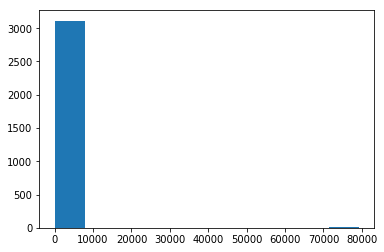

In [11]:
nums=[i for k,i in result]
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(nums)


In [16]:
for i in range(2,1000):
    num_cols=[col for col,num in result if num==i]
    if len(num_cols)>0:
        print('i=={}: nums: {}'.format(i,len(num_cols)))


i==2: nums: 3075
i==3: nums: 3
i==4: nums: 6
i==5: nums: 10
i==7: nums: 3
i==8: nums: 3
i==9: nums: 3
i==10: nums: 1
i==23: nums: 1
i==45: nums: 1
i==66: nums: 1
i==80: nums: 1
i==330: nums: 1
i==561: nums: 1


In [17]:
five_K_cols=[(col,num) for col,num in result if num>=5000]
print(five_K_cols)

[('3172', 19973), ('3156', 79065), ('3159', 79071), ('3157', 79079), ('3158', 79089), ('3164', 79255), ('3163', 79257), ('3162', 79264), ('3165', 79264), ('3166', 79264), ('3167', 79264), ('3168', 79267), ('3169', 79267), ('3170', 79267), ('id', 79267)]


#### 小结：

1. 2个值的列有3017列，其他的很多列都是几十到几百的值个数，大于5K的值个数的列有15个

2. 下面设置50个值以下的为category features

In [21]:
cat_features=[col for col,num in result if num<=50]
with open(r'E:\PyProjects\DataSet\Molecules\Baseline\Analyze/category_cols_50.csv','w') as file:
    file.write(str(cat_features))

#### 3.2 用catboost训练

In [3]:
def prepare_trainset(train_path,label_path,label_col='p1'):
    drop_cols=['0','1','2','3','4','5','19','21','26','32','38','39','40','41','42','43','44','45','46','47','48',
               '49','50','51','52','53','54','55','56','57','58','59','60','61',
              '62','63','64','65','66','67','68','69','70','71','72','73','74','75','76','77','78']
    use_cols=[str(i) for i in range(0,3177) if str(i) not in drop_cols]+['id']
    train_df=pd.read_csv(train_path,usecols=use_cols,dtype=str)
    label_df=pd.read_csv(label_path,usecols=[label_col,'id'])
    all_df=train_df.merge(label_df,on='id',how='left')
    trainy=all_df[label_col]
    trainX=all_df.drop([label_col,'id'],axis=1)
    with open(r'E:\PyProjects\DataSet\Molecules\Baseline\Analyze/category_cols_50.csv','r') as file:
        cat_feat=eval(file.readline())
    for col in trainX.columns:
        if col not in cat_feat:
            trainX[col]=trainX[col].astype(float)
    return trainX,trainy,cat_feat

In [4]:
path=r'E:\PyProjects\DataSet\Molecules\RawData\molecule_open_data/'
trainX,trainy,cat_feat=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p1')

In [5]:

# class LocalLossMetric(object):
#     def is_max_optimal(self):
#         # Returns whether greater values of metric are better
#         return False

#     def evaluate(self, approxes, target, weight):
#         # approxes is a list of indexed containers
#         # (containers with only __len__ and __getitem__ defined),
#         # one container per approx dimension.
#         # Each container contains floats.
#         # weight is a one dimensional indexed container.
#         # target is a one dimensional indexed container.
        
#         # weight parameter can be None.
#         # Returns pair (error, weights sum)
#         approx = approxes[0]

#         error_sum = 0.0
#         weight_sum = 0.0

#         for i in range(len(approx)):
#             w = 1.0 if weight is None else weight[i]
#             weight_sum += w
#             diff = np.abs(target[i] - approx[i])
#             absy_plus_babsp = (np.abs(target[i]) + np.abs(approx[i])) / 2
#             absy_plus_babsp = np.where(absy_plus_babsp==0,1e19,absy_plus_babsp) # 防止分母为0
#             loss = diff / absy_plus_babsp *100
#             error_sum += w * loss

#         return error_sum, weight_sum
    
#     def get_final_error(self, error, weight):
#         # Returns final value of metric based on error and weight
#         return error / (weight + 1e-38)


In [6]:
import catboost as cb
from catboost import Pool
def train_single_CatB(trainX,trainy, cat_feat,save_folder,seed_num=2, n_splits=5,lr=0.01):
    '''
    使用trainX,trainy, valX,valy来训练单个LGB回归器，使用K折样本融合的方式
    :param trainX:
    :param trainy:
    :param save_folder: 模型保存文件夹
    :param target_index:
    :param seed_num: 随机数的个数，每个随机数产生一个n_splits的交叉验证模型
    :param n_splits: 交叉验证的折数
    :return:
    '''

    def local_loss(y_pred, y_true):
        return 'local_loss', localLoss(y_true.get_label(), y_pred)

    os.makedirs(save_folder,exist_ok=True)
    pred_results=None
    print('trainX shape: {}'.format(trainX.shape))
    seedRandom = list(np.random.randint(0, 1000, 1000)) # 一千个随机数
    losses=[]
    
    for index, seed in enumerate(seedRandom[:seed_num]): # eg seed_num=3: enumerate([607,235,424])
        print("idx: {}, seed:{}, num:{}....".format(index,seed, seed_num))
        skf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
        preds = np.zeros((trainX.shape[0],))
        for fold_, (trn_idx, val_idx) in enumerate(skf.split(trainX)):
            print("start to train on fold {}".format(fold_ + 1))
            trnX,trny = trainX.iloc[trn_idx], trainy.iloc[trn_idx]
            valX,valy = trainX.iloc[val_idx], trainy.iloc[val_idx]
            eval_set=Pool(valX,valy,cat_features=cat_feat)
            t0=time.time()
            model=cb.CatBoostRegressor(cat_features=cat_feat,
                                       task_type="GPU",devices='0:1',loss_function="MAPE",
                n_estimators=2000,max_depth=15,learning_rate=lr,)
#                 subsample=0.8)
            model.fit(trnX,trny,eval_set=eval_set,use_best_model=True,early_stopping_rounds=20,verbose=10)
            save_name = 'CB_' +str(seed)+'_' + str(fold_)+ '_'+datetime.now().strftime('%Y%m%d_%H%M%S')
            joblib.dump(model, os.path.join(save_folder, save_name))
            print('model is fitted, take time {:.4f}, model is saved to {}'.format(time.time()-t0, save_name))
            preds[val_idx] = model.predict(valX)

        if index==0:pred_results=pd.DataFrame(preds,columns=['round_0'])
        else: pred_results['round_'+str(index)]=preds
        # 查看这个round的local loss
        loss=localLoss(trainy,preds,True)
        losses.append(loss)
    ## 最终通过平均法对pred_results计算最终预测结果，得到最终losses:
    pred_results['mean']=pred_results.mean(axis=1)
    final_loss=localLoss(trainy,pred_results['mean'].values,True)
    losses.append(final_loss)
    return losses

In [8]:
train_single_CatB(trainX,trainy, cat_feat,
                  r'E:\PyProjects\DataSet\Molecules\Baseline\CB_Models',seed_num=3, n_splits=5,lr=0.1)

trainX shape: (79267, 3126)
idx: 0, seed:854, num:3....
start to train on fold 1
0:	learn: 0.4425589	test: 0.4437505	best: 0.4437505 (0)	total: 1.42s	remaining: 47m 18s
10:	learn: 0.3642787	test: 0.3704095	best: 0.3704095 (10)	total: 15.4s	remaining: 46m 27s
20:	learn: 0.3282779	test: 0.3390703	best: 0.3390703 (20)	total: 29.4s	remaining: 46m 12s
30:	learn: 0.3066746	test: 0.3222726	best: 0.3222726 (30)	total: 45.6s	remaining: 48m 18s
40:	learn: 0.2885543	test: 0.3092703	best: 0.3092703 (40)	total: 1m 1s	remaining: 49m 8s
50:	learn: 0.2730700	test: 0.2996207	best: 0.2996207 (50)	total: 1m 18s	remaining: 50m 10s
60:	learn: 0.2596456	test: 0.2916124	best: 0.2916124 (60)	total: 1m 35s	remaining: 50m 34s
70:	learn: 0.2489509	test: 0.2857393	best: 0.2857393 (70)	total: 1m 50s	remaining: 49m 54s
80:	learn: 0.2392797	test: 0.2805269	best: 0.2805269 (80)	total: 2m 5s	remaining: 49m 31s
90:	learn: 0.2313862	test: 0.2767309	best: 0.2767309 (90)	total: 2m 20s	remaining: 49m 4s
100:	learn: 0.22437

[30.181369601894186, 30.16829489801481, 30.216842165168586, 29.42107679262542]

In [ ]:
import gc
del trainX,trainy
gc.collect()
trainX,trainy,cat_feat=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p2')
losses=train_single_CatB(trainX,trainy, cat_feat,
                  r'E:\PyProjects\DataSet\Molecules\Baseline\CB_Models',seed_num=3, n_splits=5,lr=0.1)

trainX shape: (79267, 3126)
idx: 0, seed:49, num:3....
start to train on fold 1
0:	learn: 0.0420165	test: 0.0420697	best: 0.0420697 (0)	total: 1.55s	remaining: 51m 42s
10:	learn: 0.0448621	test: 0.0460209	best: 0.0419247 (1)	total: 17.3s	remaining: 52m 12s
20:	learn: 0.0430719	test: 0.0459802	best: 0.0419247 (1)	total: 33.9s	remaining: 53m 18s
bestTest = 0.04192473853
bestIteration = 1
Shrink model to first 2 iterations.
model is fitted, take time 78.1509, model is saved to CB_49_0_20200330_214417
start to train on fold 2
0:	learn: 0.0414628	test: 0.0415679	best: 0.0415679 (0)	total: 1.68s	remaining: 56m 5s
10:	learn: 0.0434994	test: 0.0436894	best: 0.0415679 (0)	total: 18.1s	remaining: 54m 40s
20:	learn: 0.0424907	test: 0.0438874	best: 0.0415679 (0)	total: 35.5s	remaining: 55m 44s
bestTest = 0.04156786727
bestIteration = 0
Shrink model to first 1 iterations.
model is fitted, take time 78.1258, model is saved to CB_49_1_20200330_214558
start to train on fold 3
0:	learn: 0.0421266	test:

In [ ]:
import gc
del trainX,trainy
gc.collect()
trainX,trainy,cat_feat=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p3')
losses=train_single_CatB(trainX,trainy, cat_feat,
                  r'E:\PyProjects\DataSet\Molecules\Baseline\CB_Models',seed_num=3, n_splits=5,lr=0.1)

In [ ]:
import gc
del trainX,trainy
gc.collect()
trainX,trainy,cat_feat=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p4')
losses=train_single_CatB(trainX,trainy, cat_feat,
                  r'E:\PyProjects\DataSet\Molecules\Baseline\CB_Models',seed_num=3, n_splits=5,lr=0.1)

In [ ]:
import gc
del trainX,trainy
gc.collect()
trainX,trainy,cat_feat=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p5')
losses=train_single_CatB(trainX,trainy, cat_feat,
                  r'E:\PyProjects\DataSet\Molecules\Baseline\CB_Models',seed_num=3, n_splits=5,lr=0.1)

In [ ]:
import gc
del trainX,trainy
gc.collect()
trainX,trainy,cat_feat=prepare_trainset(path+"candidate_train.csv",path+"train_answer.csv",label_col='p6')
losses=train_single_CatB(trainX,trainy, cat_feat,
                  r'E:\PyProjects\DataSet\Molecules\Baseline\CB_Models',seed_num=3, n_splits=5,lr=0.1)